# Intro to Fraud Detection

<span>This notebook is an extensive look into different Fraud Detection Models. I started this project without any knowledge of Fraud Detection and slowly worked my up during my education at BrainStation. I initially modeled many more models than presented here, but I decided to cut the majority of them to communicate the best models and reduce the size of this notebook.</span>
    
**Dataset:** [Paysim Transactions Logs](https://www.kaggle.com/ntnu-testimon/paysim1)
    
##### Scientific Notes 

-- Most of the heavy lifting is in the function. I have writting some documentation below every custom function.<br>
-- I created hold out data set containin 50% of the data before I do any of my descriptive analysis. Tne holdout set is used a second test set to make suer my final model is not overfitting on the test scores visible within my confusion matrices. Just trying remove the probability my own personal bias.<br>


### Import Preliminaries

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import Modules
import datetime
import itertools
import graphviz
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy
import sklearn
import tensorflow as tf
import warnings
import xgboost

# Other Imports
from matplotlib import rcParams, gridspec
from scipy import io
from xgboost import XGBClassifier

# Keras Imports
from keras import models, layers
from keras import regularizers

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier

# Scipy Imports
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Preprocesing
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

# Sklearn Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report,
                             f1_score, precision_score, recall_score,
                             precision_recall_fscore_support, roc_auc_score)

# Model Selection
from sklearn.model_selection import (cross_val_score, KFold, train_test_split,
                                     GridSearchCV, cross_validate,
                                     StratifiedKFold)


# Set Numpy and Python Random Seed
seed = 7
np.random.seed(seed)

# Pandas Configuration
pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Warning Configuration
warnings.filterwarnings('ignore')

# Plotting Configuration
rcParams['figure.figsize'] = (12.0, 4.0)
rcParams.update({'font.size': 10})
colors = ['#74a9cf', '#6a51a3']

# Print versions of each package above 
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Sklearn version: {}".format(sklearn.__version__))
print("Keras version: {}".format(keras.__version__))
print("Scipy version: {}".format(scipy.__version__))
print("XBG Boost version: {}".format(xgboost.__version__))

Numpy version: 1.14.5
Pandas version: 0.23.4
Sklearn version: 0.19.0
Keras version: 2.2.2
Scipy version: 0.19.1
XBG Boost version: 0.72


<br><br>
<a id='function'></a>
### Functions

I have created many functions to the make later part of our code more simplistic. You will see some measurement functions which we will use in Keras. a few functions used to plot our confusion matrices. Finally a few transformation functions that transform depentand values from +1/1 to 0/1.

In [29]:
def anon_to_target(array):
    '''
    Converts Prediction in the +1/-1 format to 0/1 format for every value in the array

    Parameter
    ---------
    array: numpy array containing only +1/1

    Exmaples
    ---------
    >>>> anon_to_targets([1,1,,1,1,-1,1,-1,1])
    '''

    array = [0 if i == 1 else 1 for i in array]
    array = np.array(array).reshape(1, -1)[0]

    return array

def plot_confusion_anomoly(model, classes, name,
                           train_y, test_y, train_x,test_x,
                           cmap=plt.cm.Purples):
    '''
    Function plots a confusion matrix given train and test 
    unsuperived models

    Parameters
    ----------
    train_model: sklearn/keras model object to be trained on training data
    test_moedl: sklearn/keras model object to be trained on test data

    Examples
    ----------
    >>>> plot_confusion_anomoly(xg_model, train_x, train_y)
    >>>> plot_confusion_anomoly(rf_model, train_x, train_y)
    '''
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Plot Train Confusion Matrix
    fig = gridspec.GridSpec(3,3)
    grid_length = list(range(1,3))
    tuple_grid = [(i,j) for i in grid_length for j in grid_length]

    plt.subplot2grid((3,3), (0,0))
    cm = confusion_matrix(train_y, anon_to_target(model.predict(train_x)))
    plot_confusion_matrix(cm, classes, fontsize=20, 
                          title=name,
                         normalize=True, cmap=cmap)
    
    plt.subplot2grid((3,3), (0,1))
    cm = confusion_matrix(test_y, anon_to_target(model.predict(test_x)))
    plot_confusion_matrix(cm, classes, fontsize=20,
                          title=name,
                         normalize=True, cmap=cmap);

    return None


def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    THE MAIN CONFUSION MATRIX, KAVI DON'T DELTETE BY ACCIDENT AGAIN. Function plots a 
    confusion matrix given a cm matrix and class names

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ---------
    >>>>

    plot_confusion_matrix(
    cm,
    classes,
    fontsize=25,
    normalize=True,
    title=model.name.capitalize() + ': Test Set',
    cmap=plt.cm.Greens)

    '''
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        None
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None

def plot_confusion_normal(model, classes, name, train_x, train_y,
                          test_x, test_y, cmap=plt.cm.Greens):
    '''
    Fuction plota grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_normal(xg_model, train_x, train_y)
    >>>> plot_confusion_normal(rf_model, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Test Set',
        cmap=cmap)

    return None        


def plot_confusion_neural(model, classes, train_x, train_y, 
                          test_x, test_y, cmap=plt.cm.Oranges):
    '''
    Funtion to plot a grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set. This function includes a sigmoid function that rounds
    networks prediction before plotting.

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_neural(nn_model, train_x, train_y)
    >>>> plot_confusion_neural(autoencoder, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=model.name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, (model.predict(test_x)))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=model.name.capitalize() + ': Test Set',
        cmap=cmap)

    return None


def target_to_anon(array):
    '''
    Converts prediction in the 
    0/1 standard format to 1/-1 anomoly format for every
    value in the array

    Parameter
    ---------
    array: numpy array containing only +1/1

    Exmaples
    ---------
    >>>> anon_to_targets([1,1,,1,1,-1,1,-1,1])
    '''
    array = [1 if i == 0 else -1 for i in array]
    array = np.array(array).reshape(1,-1)[0]
    return array

def read_csv(path: str, lower=True) -> pd.DataFrame:
    '''Read in csv data return dataframe after lowering all columns name
    
    Parameters
    ----------
    path: Absolulte or Relative Path to csv data
    
    '''
    df = pd.read_csv('Data/Synthetic/synthetic.csv')
    if lower == True:
        df.columns = df.columns.str.lower()
    return df

# Customer summary stastitics dataframe
def sum_stat(df:pd.DataFrame) -> pd.DataFrame:
    '''
    Plot the summary statitic of a dataframe. The statistics 
    include the normal describe statistics as well as additional
    median value, and counts on the number of unique values and
    null values
    
    Parameters
    ----------
    
    df: A pandas dataframes of datate
    '''
    
    sum_df = pd.concat([df.describe(), 
           pd.DataFrame(df.nunique(), columns=['nuniques']).T,
           pd.DataFrame(np.sum(df.isnull(), axis =0), columns=['isnull']).T],
           axis=0)
    return sum_df

def grid_search_groupby(results: pd.DataFrame, param_1: str, param_2: str) -> pd.DataFrame:
    '''
    Create a aggregated dataframe from the grid search results use the two
    hyper paramters that we pass into the function. We will be using this
    function to plot heatmaps from our grid search.

    Parameters
    ----------
    results: DataFrame of Grid Score results.

    Examples
    ----------
    >>> (grid_search_groupby(results,'max_depth','n_estimators')
    >>> grid_search_groupby(results,'max_leaf_nodes','n_estimators')
    '''
    assert (type(results) ==  type(pd.DataFrame())), 'results should be a pandas.core.frame.DataFrame'
    assert (type(param_1) == str), 'param_1 should be a string'
    assert (type(param_2) == str), 'param_2 should be a string'

    params_df  = pd.DataFrame.from_dict(list(results.params.values))
    mean_test_score = results.mean_test_score
    result_shrt_df = pd.concat([mean_test_score, params_df], axis=1)
    result_groupby = result_shrt_df.groupby([param_1, param_2])['mean_test_score'].mean().unstack()
    return result_groupby

### Import Data

In [32]:
# Import paysim data
sdf = read_csv('Data/Synthetic/synthetic.csv')
sdf = sdf.rename(columns={'isfraud':'target', 'oldbalanceorg':'oldbalanceorig'})

# Create a holdout dataset with 50% of the data. 3 milliion+ rows each.
holdout_index = np.random.choice(np.arange(0,sdf.shape[0]), size=int(sdf.shape[0]*0.5),replace=False)
sdf_holdout = sdf[sdf.index.isin(holdout_index)]
sdf = sdf[~sdf.index.isin(holdout_index)]
sdf.head(10000)

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0
8,1,PAYMENT,4024.360,C1265012928,2671.000,0.000,M1176932104,0.000,0.000,0,0
13,1,PAYMENT,11633.760,C1716932897,10127.000,0.000,M801569151,0.000,0.000,0,0
15,1,CASH_OUT,229133.940,C905080434,15325.000,0.000,C476402209,5083.000,51513.440,0,0
16,1,PAYMENT,1563.820,C761750706,450.000,0.000,M1731217984,0.000,0.000,0,0
20,1,PAYMENT,1373.430,C20804602,13854.000,12480.570,M1344519051,0.000,0.000,0,0
23,1,PAYMENT,3876.410,C504336483,67852.000,63975.590,M1404932042,0.000,0.000,0,0
26,1,PAYMENT,9478.390,C1671590089,116494.000,107015.610,M58488213,0.000,0.000,0,0
31,1,PAYMENT,4206.840,C215078753,0.000,0.000,M1757317128,0.000,0.000,0,0


### Pay Sim Finanicial Logs

This notebook will tackle a problem that comes from a [PaySim](http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1058442&dswid=7771) Simulator which has provided a dataset of simulated transactions from one month of financial logs. The logs came from a mobile money service within an unknown African nation. In, this next cells I will use this dataset to review some supervised learning approaches to detection. Agents in this dataset are attempting to control customers accounts and empty the funds by transferring to another account and then cashing out of the system. The "isflaggedfraud" feature in the dataset is flag this active when someone attempts to transact more than 200,000. We will drop this feature from our supervised model as it is a form of data leakage as all 'isflaggedfraud" transactions are fraudulent transactions.

In [33]:
# View head of the dataframe
sdf.head(3)

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0
8,1,PAYMENT,4024.360,C1265012928,2671.000,0.000,M1176932104,0.000,0.000,0,0


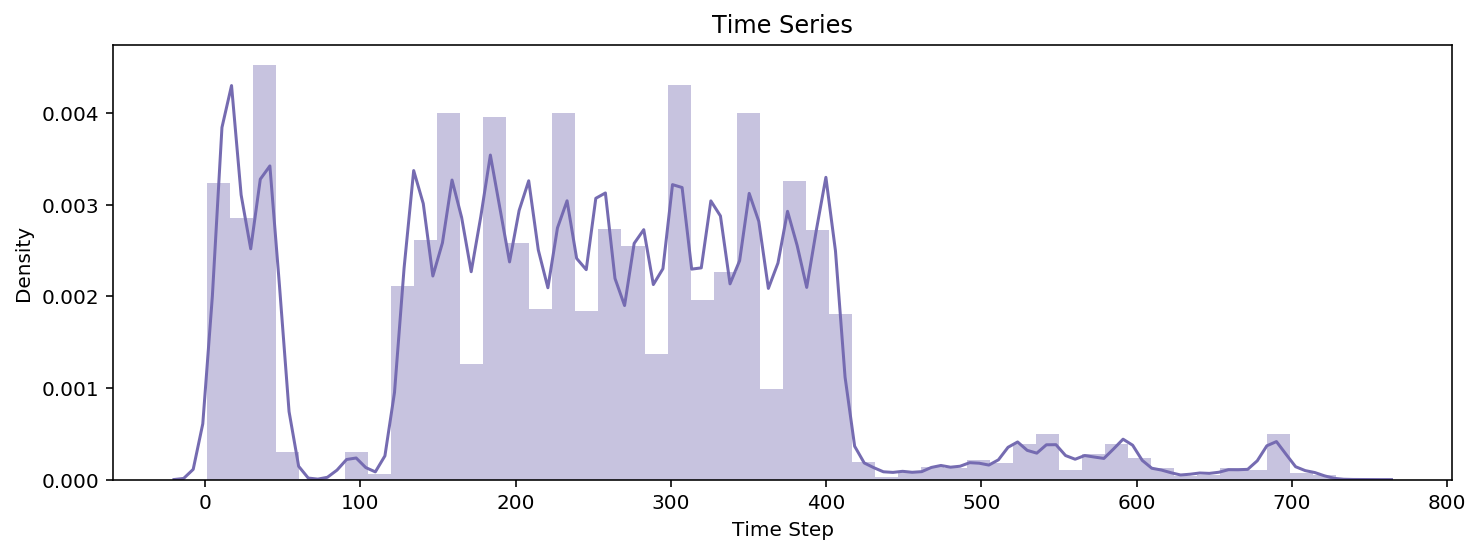

In [34]:
# Plot number of datapoints of each time interval
plt.figure(figsize=(12,4))
sns.distplot(sdf.step, color='#756bb1');
plt.title('Time Series')
plt.xlabel('Time Step'); plt.ylabel('Density');

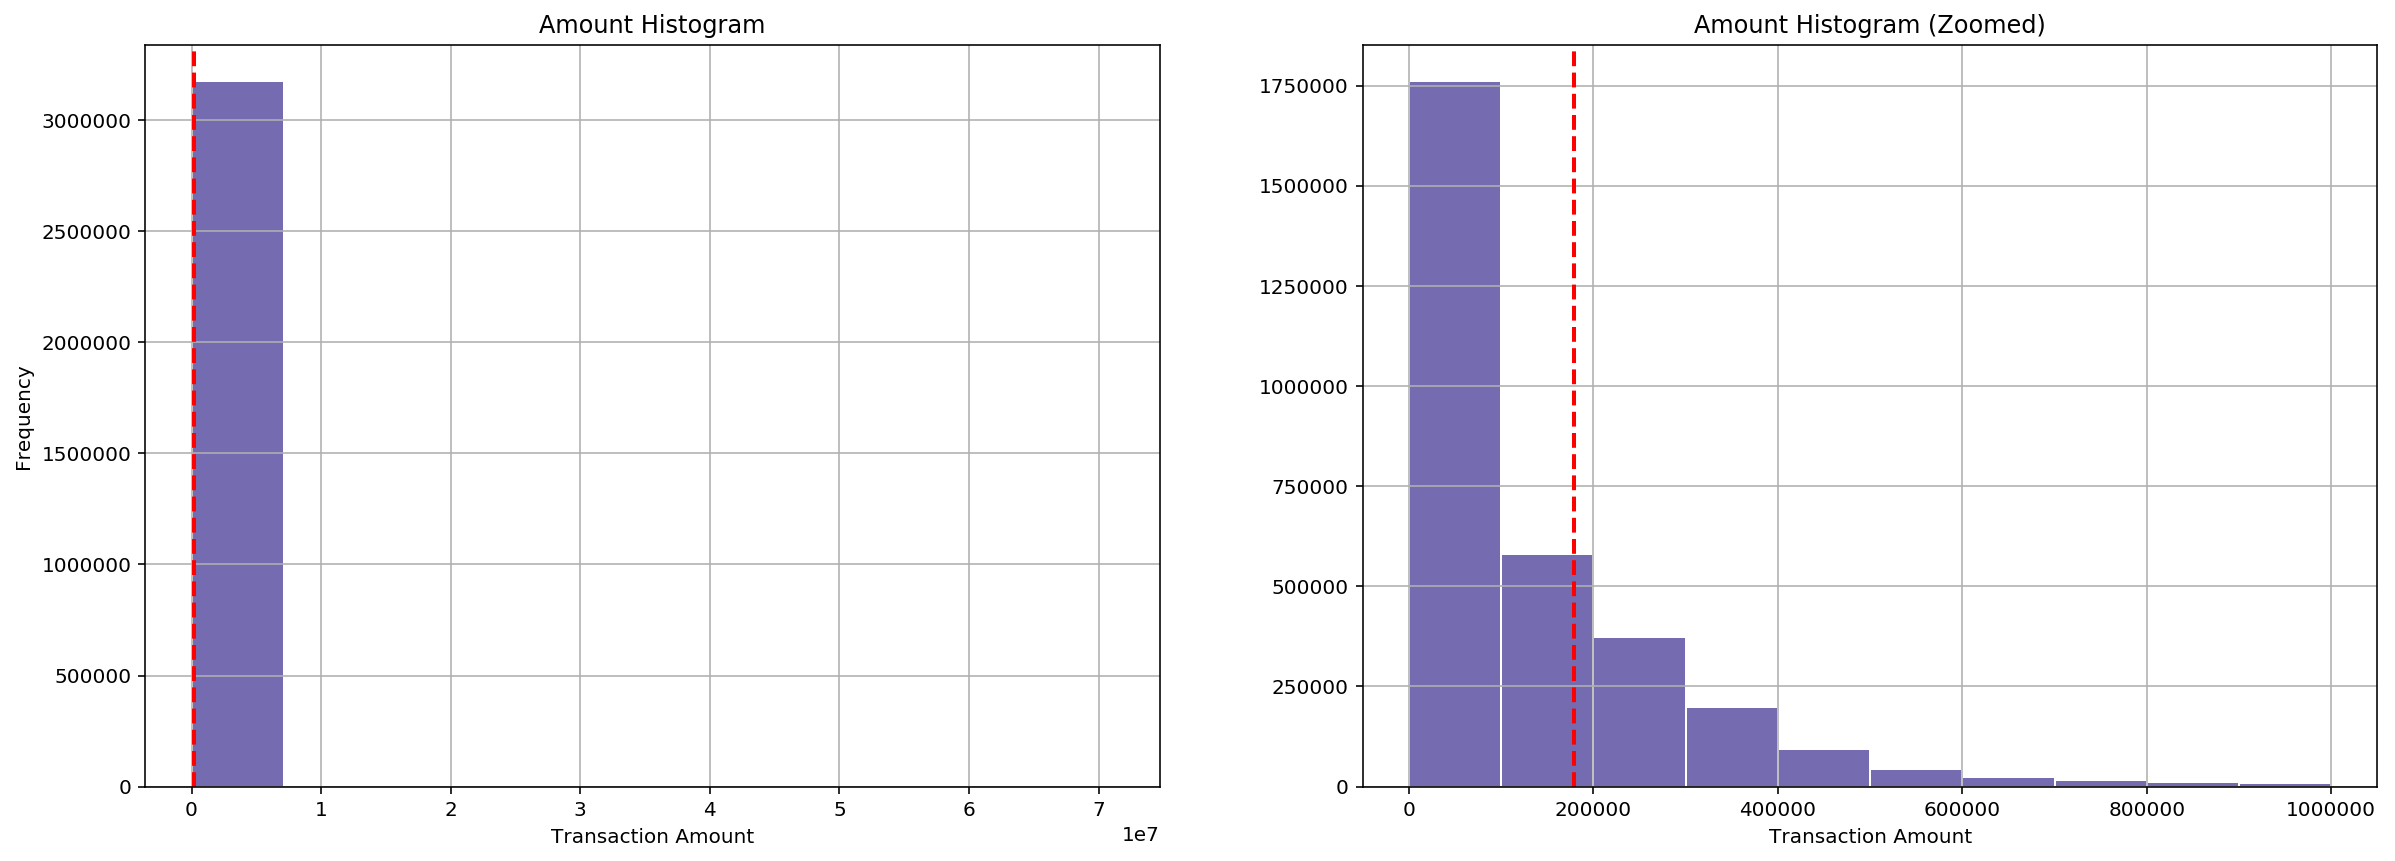

In [13]:
# Plot histograms of amounts
plt.figure(figsize=(20,15))
plt.subplot2grid((2, 2), (0, 0))
sdf.amount.hist(color='#756bb1',  edgecolor='white')
plt.axvline(sdf.amount.mean(),  
            color='r', linestyle='dashed', linewidth=2);
plt.title('Amount Histogram')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency');

# Plot zoomed histograms of amounts
plt.subplot2grid((2, 2), (0, 1))
sdf[sdf.amount < 10_000_00].amount.hist( color='#756bb1',  
                                        edgecolor='white')
plt.axvline(sdf.amount.mean(),  
            color='r', linestyle='dashed', linewidth=2)
plt.title('Amount Histogram (Zoomed)')
plt.xlabel('Transaction Amount');

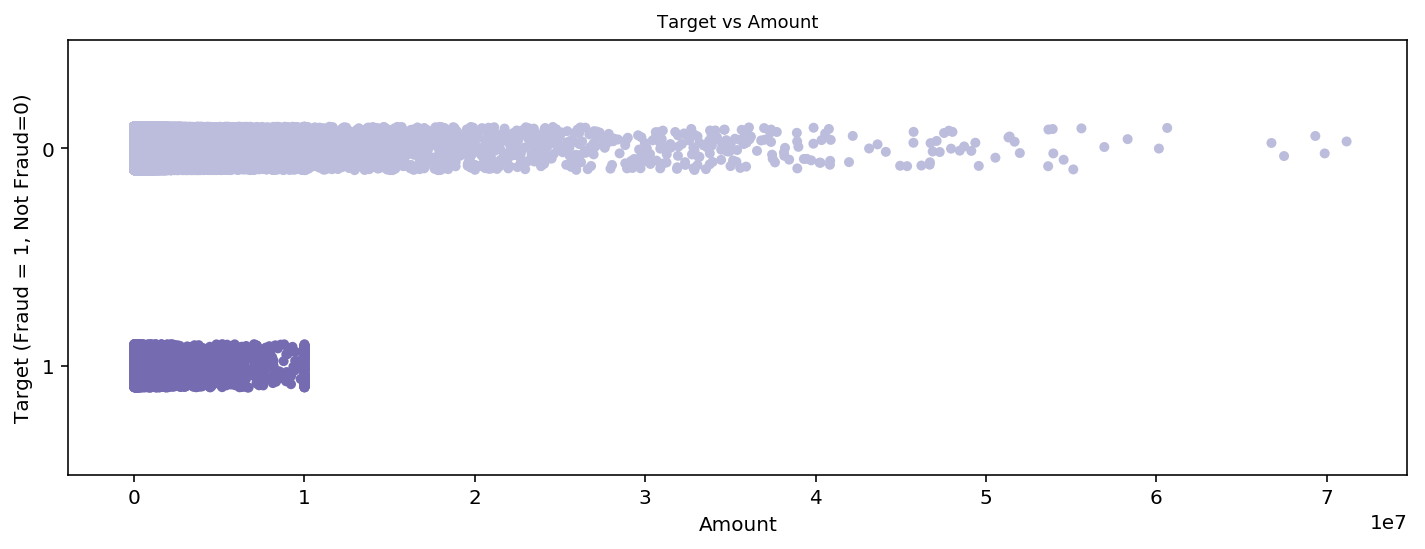

In [14]:
# Plotting frequency of fraud amounts by fraud classification
sns.stripplot(x=sdf["amount"], y=sdf['target'].astype('category'),
             palette=['#bcbddc','#756bb1']);
plt.title('Target vs Amount', fontsize=9)
plt.xlabel('Amount',)
plt.ylabel('Target (Fraud = 1, Not Fraud=0)',);

##### Aggregation Statistics

In [15]:
# View a cross tab for the number of transactions in the dataset
pd.crosstab(sdf.type, sdf.target)

target,0,1
type,,
CASH_IN,699017,0
CASH_OUT,1116491,2124
DEBIT,20782,0
PAYMENT,1076533,0
TRANSFER,264311,2052


In the description of the data source, the author notes that the cases of fraud within this dataset are acts committed by individuals attempting to empty out a bank account at once. The crosstab shows us that our fraudsters are going about this by transfer the cashout or transferring it to another account.

In [16]:
# Data Leak: All the cases where "isflaggedfraud" = 1, are already
# fraudualent transractions. I will be removing this feature during
# the feature engineering of this dataset.
sdf[['target','isflaggedfraud']].groupby('target').sum()

,isflaggedfraud
target,
0,0
1,8


Know we are going to create some feature that can tell us a bit more about the victim from these fraudulent transactions. I will aggregate our transaction data frame into dataset based on users. The purpose here is to see whether the same users are involved in multiple transactions. Note that this dataset does.

In [17]:
# View accounts that tranfer the amount to their own acccount (None)
sdf[sdf['nameorig'] == sdf['namedest']]

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud


Looks like dataset only containes information on transfer to external accounts, and not transfer to ones own account (chequeing to savings). This is good to know.

In [18]:
# Count how many clients were affected at lease twice
affeceted_clients = sdf[sdf.target == 1]
affeceted_clients[['nameorig','namedest']]
affeceted_clients_list = pd.Series(affeceted_clients['nameorig'], name='clients')
affeceted_clients_list.append(pd.Series(affeceted_clients['namedest']))
affeceted_clients_list = affeceted_clients_list.value_counts()

# Prin counts
print(f'Number of Clients Affected Once: \
{affeceted_clients_list[affeceted_clients_list <= 1].count()}')
print(f'Number of Clients Affected More than once: \
{affeceted_clients_list[affeceted_clients_list > 1].count()}')

Number of Clients Affected Once: 4176
Number of Clients Affected More than once: 0


No one in our fraud dataset has been involved in a case of fraud more than once. Good news seems like there are not repeat bat actors.

##### Assessing Fraudelent Transactions

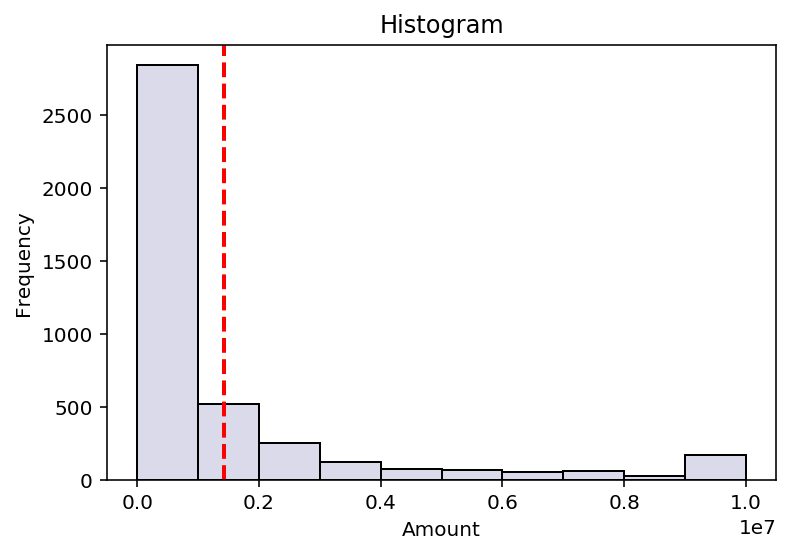

In [19]:
# Histogram of only fraudulent amounts
rcParams['figure.figsize'] = (6.0, 4.0)
fraud_transactions = sdf[sdf.target == 1]
fraud_transactions.amount.plot.hist(color='#dadaeb', 
                                    edgecolor='black', )
plt.title('Histogram')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.axvline(sdf[sdf.target == 1].amount.mean(),  color='r', linestyle='dashed', linewidth=2);

##### Creating a Network Graph

The data is a transaction database retrieved from a relational database. We can you the NetworkX Python package to create a temporary graph database/network. We can then create a network plot to view if there are any patterns within the network.

In [20]:
# Create a list of all the accounts involved in fraud
fraud_case_accounts = sdf[sdf.target == 1][['nameorig','namedest']].values
fraud_case_accounts = fraud_case_accounts.reshape(-1,1)
fraud_case_accounts_list = np.unique(fraud_case_accounts)

# Generate a dataframe of all the transactions carried out by these
# individuals
sdf_fraud_scope = sdf[(sdf.nameorig.isin(fraud_case_accounts_list)) | (
    sdf.namedest.isin(fraud_case_accounts_list))]

# Print metric counts
print('Number of Cases of Fraud:',sdf[sdf.target == 1].shape[0])
print('Number of Accounts involved in Fraud (2 per transaction):',
      len(fraud_case_accounts_list))
print('Number of Total Transactions involed with these Accounts:',
     len(sdf_fraud_scope))

Number of Cases of Fraud: 4176
Number of Accounts involved in Fraud (2 per transaction): 8343
Number of Total Transactions involed with these Accounts: 19227


First I have graphed the fraudulent transactions in the dataset. Note the arrow within this Bidirectional graph show us the direction in which money is flowing.

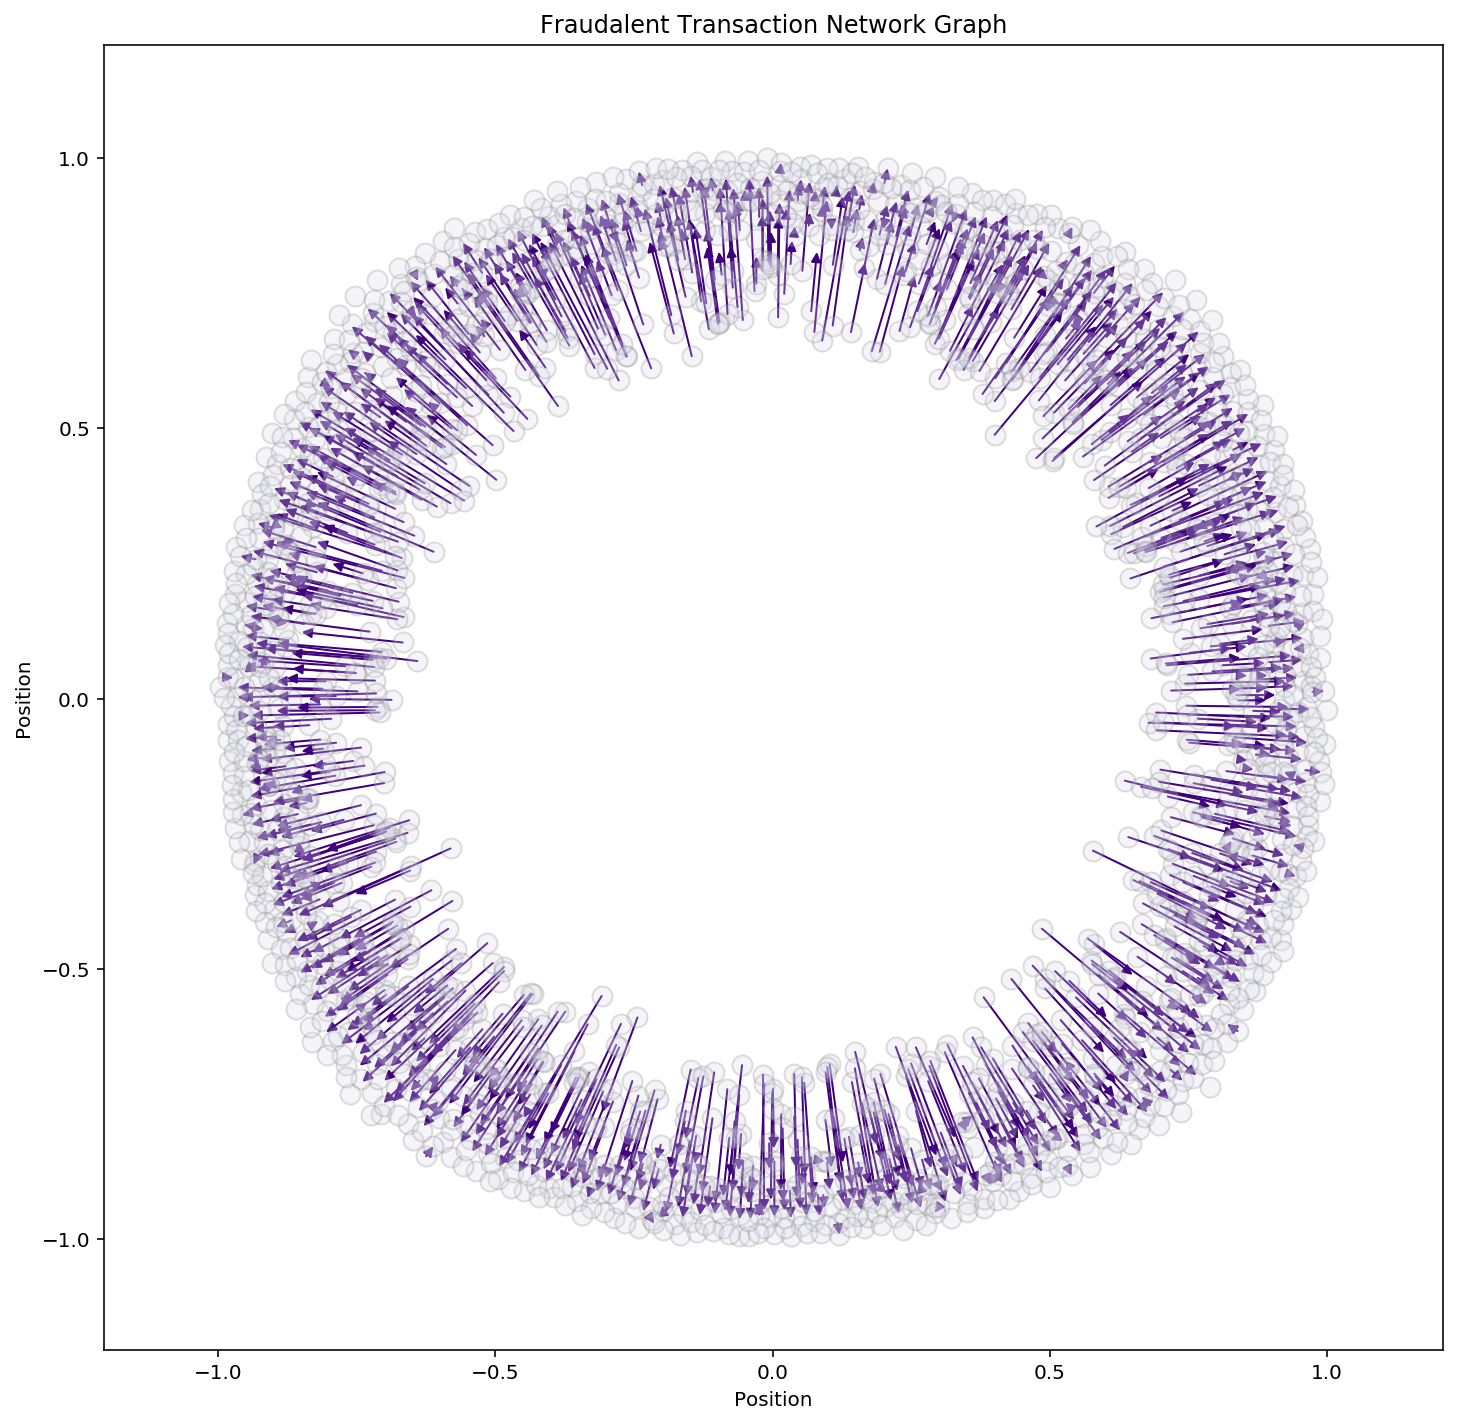

In [21]:
# Set a new default figure size for plotting
rcParams['figure.figsize'] = (12.0, 12.0)

# Segment out graph data
data = sdf[sdf.target == 1].sample(1000)
data = data[['nameorig','namedest','target','amount']]
G = nx.DiGraph()

# Create temporary graph database/network
for i,j,k,l in list(data.itertuples(index=False, name=None)):
    G.add_edge(i,j, target=k, amount=l )

# Plot the graph network
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos, alpha=0.25,
                       node_size=100,
                       node_color='#dadaeb',
                       edgecolors='grey');
nx.draw_networkx_edges(G,pos,edge_color='#3f007d',
                       width=1,
                       arrowsize=10,
                      arrowstyle='-|>',
                      )
plt.title('Fraudalent Transaction Network Graph')
plt.xlabel('Position')
plt.ylabel('Position');

The plot above is plotting out every fraudulent transaction. The arrow shows us which the money was following. Each not represents a bank account. We can see that many of the bank accounts had been involved in case of fraud once as either the sender and receiver. Next, We will look at all the historical transaction from all these accounts before after the instances of fraud. I want to see if the total amount of transactions show any pattern. If one exists, we could use that information as an explicit feature in our feature engineering.

**Note**: AIF = "Accounts that were involved with at least one fraudelents accounts, both sender and reciever included

In [22]:
# Turn numyp arraay into a series
AIF_sample = pd.Series(fraud_case_accounts_list)

# Filter out our data by the account that have been involved with fraud
AIF_sample_df = sdf[(sdf.nameorig.isin(AIF_sample)) | (
    sdf.namedest.isin(AIF_sample))]

AIF_sample_data = AIF_sample_df[['nameorig','namedest','target','amount']]

# Create a new graph database/network with AIP info 
GF = nx.DiGraph()
for i,j,k,l in list(AIF_sample_data.itertuples(index=False, 
                                               name=None)):
    GF.add_edge(i,j, target=k, amount=l )

    
# Create a dataframe aggregating neighbour counts for
# each node 
node_list = []
neighbor_amount = []
counter = 0
for node in list(GF.nodes):
    counter=0
    for neighbour in nx.all_neighbors(GF,node):
        counter+=1
    node_list.append(node)
    neighbor_amount.append(counter)
neighbor_counts = pd.DataFrame({'nodes':node_list,'neighbor_amount': neighbor_amount})

# Print the results of the Aggregation
print('Total transaction with AIF accounts:',
      round(neighbor_counts.neighbor_amount.mean(),4))
print('Number of AIF Accounts with 1 Transaction:', 
      len(neighbor_counts[neighbor_counts.neighbor_amount == 1]))
print('Number of AIF Accounts with 1+  Transactions:', 
      len(neighbor_counts[neighbor_counts.neighbor_amount > 1].count()))

Total transaction with AIF accounts: 1.6438
Number of AIF Accounts with 1 Transaction: 20843
Number of AIF Accounts with 1+  Transactions: 2


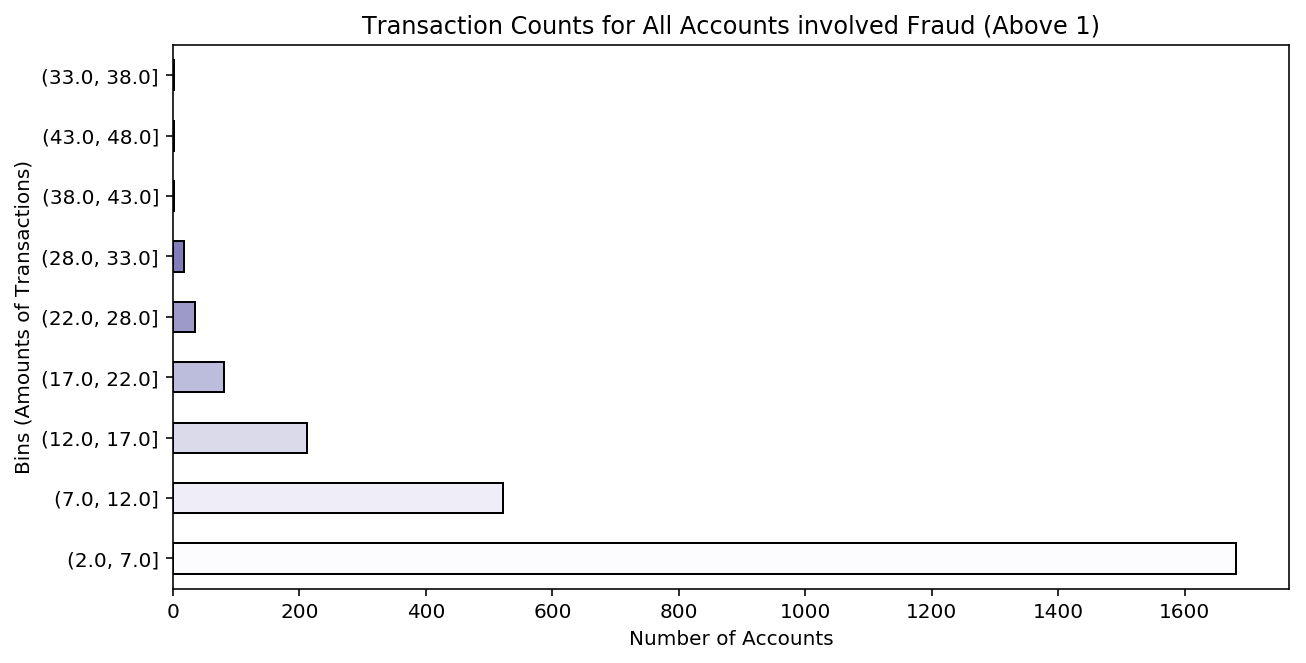

In [23]:
plt.figure(figsize=(10,5))
data = neighbor_counts[neighbor_counts.neighbor_amount > 1]
neighbor_counts_cut = pd.cut(data.neighbor_amount, bins=9, precision=0)
neighbor_counts_cut.value_counts().plot.barh(color=['#fcfbfd','#efedf5','#dadaeb','#bcbddc',
                                                    '#9e9ac8','#807dba','#6a51a3','#54278f',
                                                    '#3f007d'],edgecolor='black');
plt.title('Transaction Counts for All Accounts involved Fraud (Above 1)')
plt.ylabel('Bins (Amounts of Transactions)')
plt.xlabel('Number of Accounts');

### Preprocessing

Moving forward in the analysis I will be using the entire dataset. There is some more descripitve analysis in the next feature engineering section. After feature engineering, I will be writng the best performing models. 

##### Feature Engineering

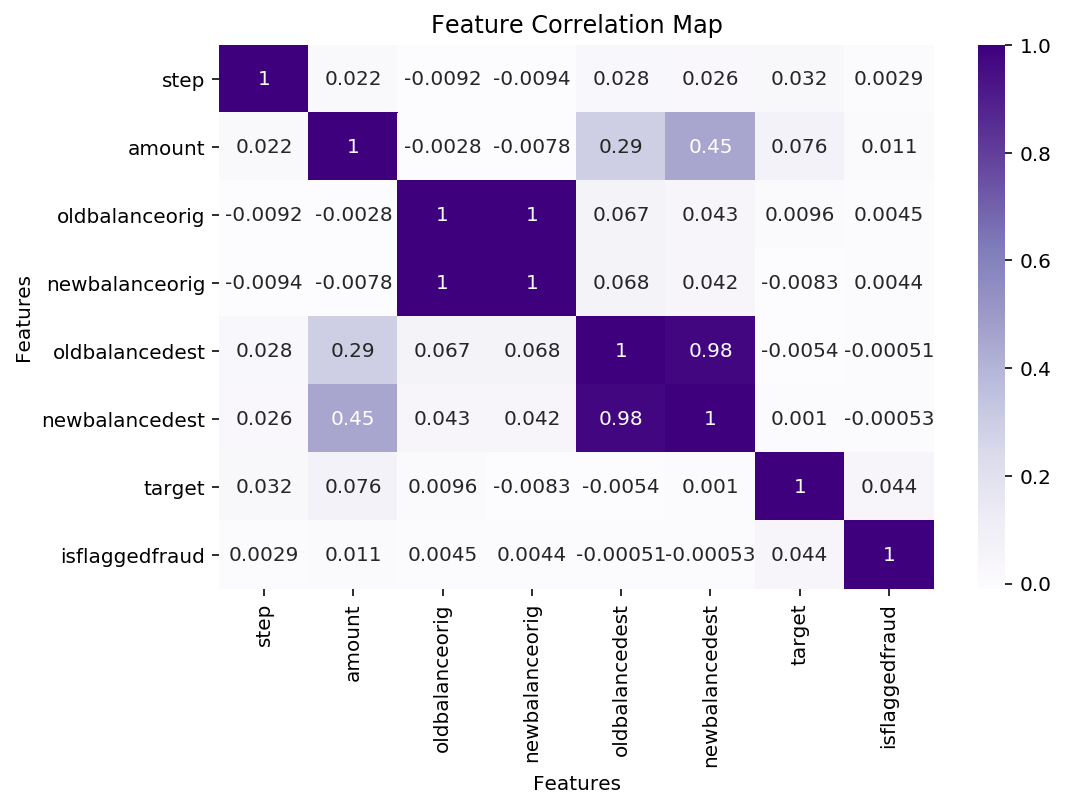

In [24]:
plt.figure(figsize=(8,5))
sns.heatmap(sdf.select_dtypes(['int','float']).corr(), 
            cmap=plt.cm.Purples, annot=True);
plt.title('Feature Correlation Map');
plt.ylabel('Features')
plt.xlabel('Features')
plt.xticks(rotation='vertical');

Ideally, we want to see high variance and very little correlation in our feature matrix before modeling. The correlation matrix above shows that new and old balance features are highly correlated.

In [25]:
sdf[['newbalancedest','oldbalancedest']].describe()

,newbalancedest,oldbalancedest
count,3181310.000,3181310.000
mean,1223953.595,1100163.187
std,3657349.095,3390669.528
min,0.000,0.000
25%,0.000,0.000
50%,214227.905,132146.085
75%,1111662.308,942665.370
max,356179278.920,356015889.350


We can see from the summary statics provided above that the means are very close. Let's plot this out and view the correlation.

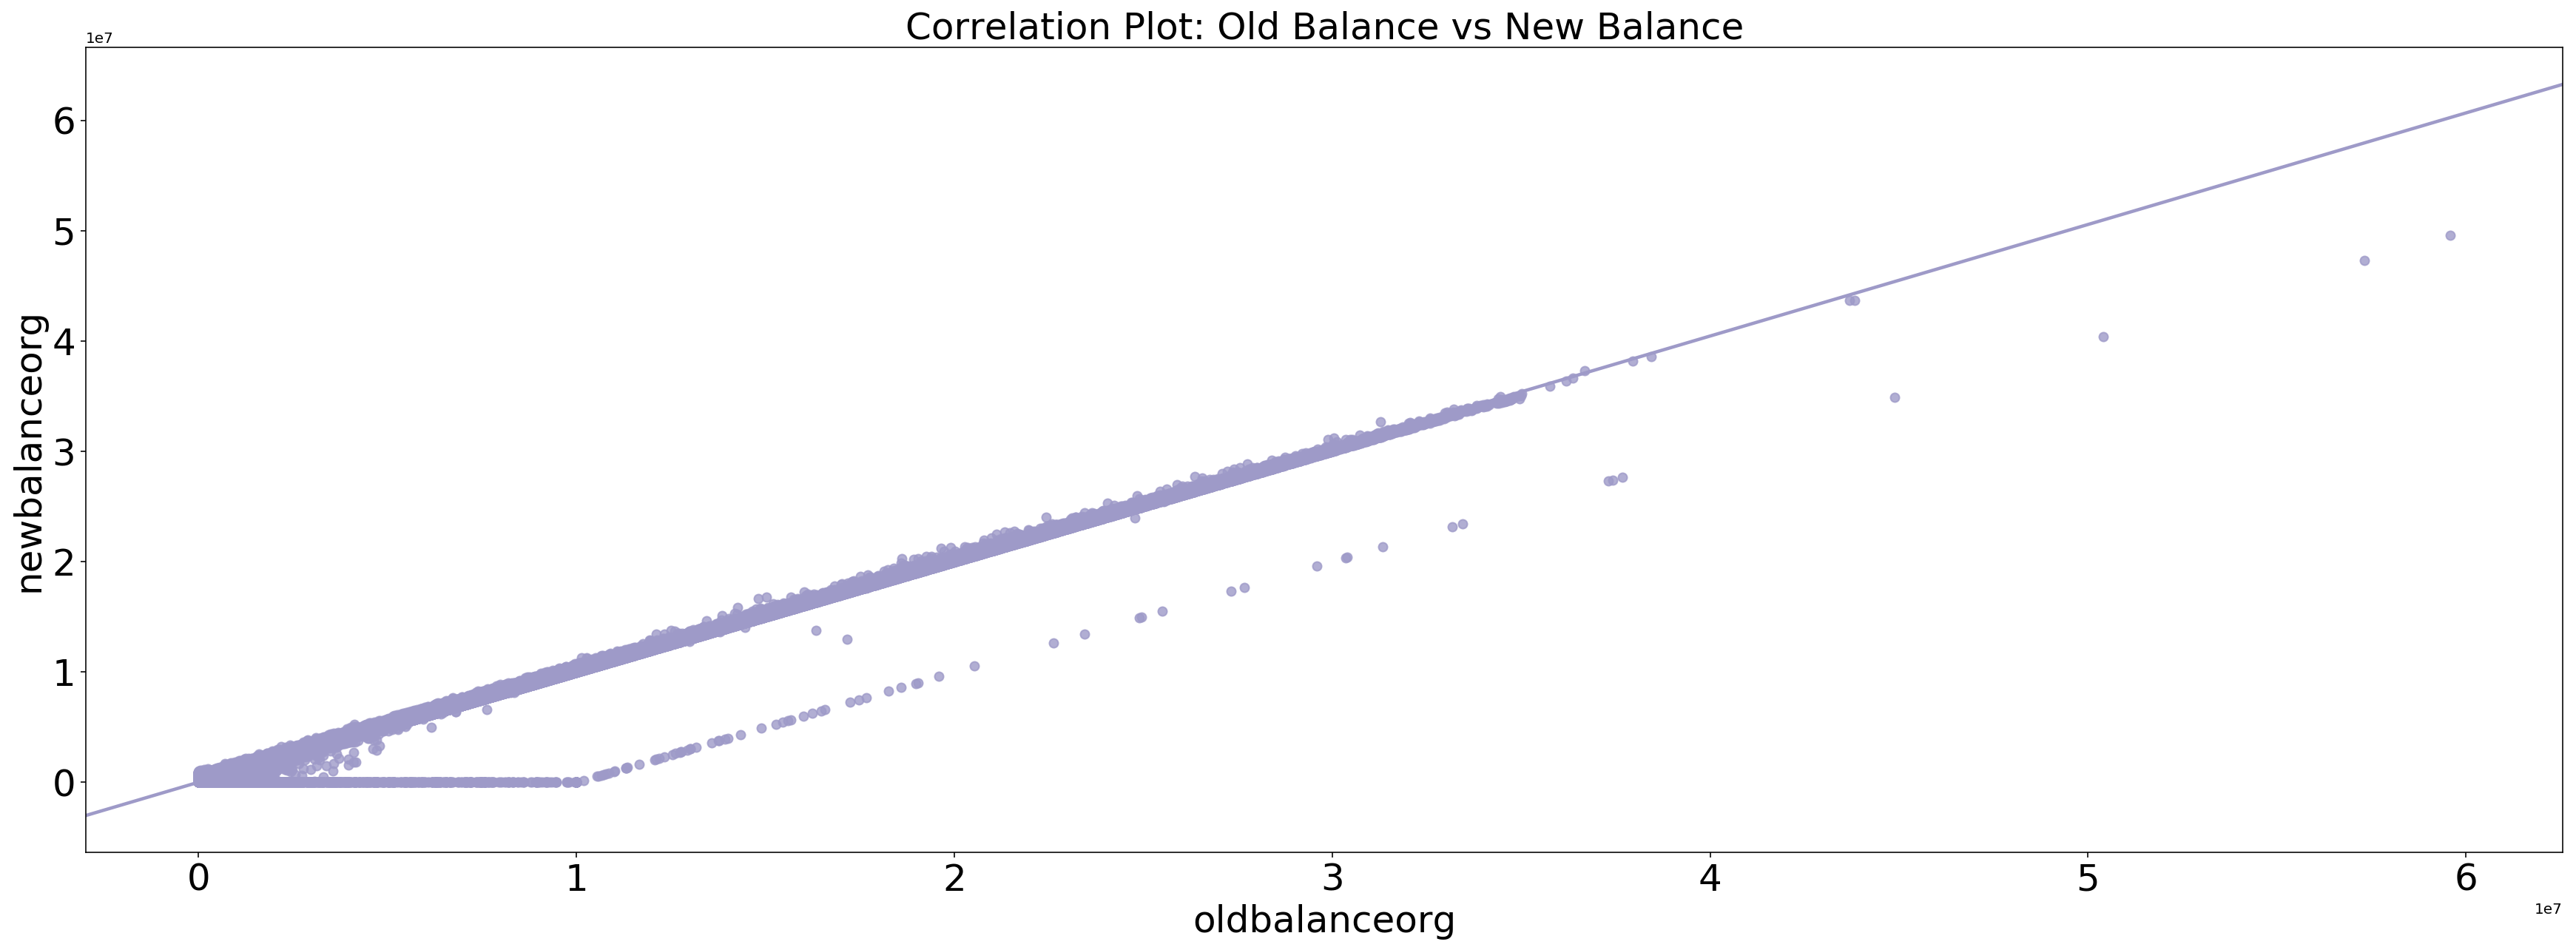

In [26]:
plt.figure(figsize=(30,10))
sns.regplot(x="oldbalanceorig", y="newbalanceorig", 
            data=sdf, color='#9e9ac8')
plt.title('Correlation Plot: Old Balance vs New Balance',fontsize=25)
plt.xlabel('oldbalanceorg', fontsize=25)
plt.ylabel('newbalanceorg',fontsize=25);
plt.yticks(fontsize=25);
plt.xticks(fontsize=25);

The correlation does not merely look like a strong linear correlation. There are two different trends between the feature within this plot.  Segmenting the data by our target value would be the best next step.

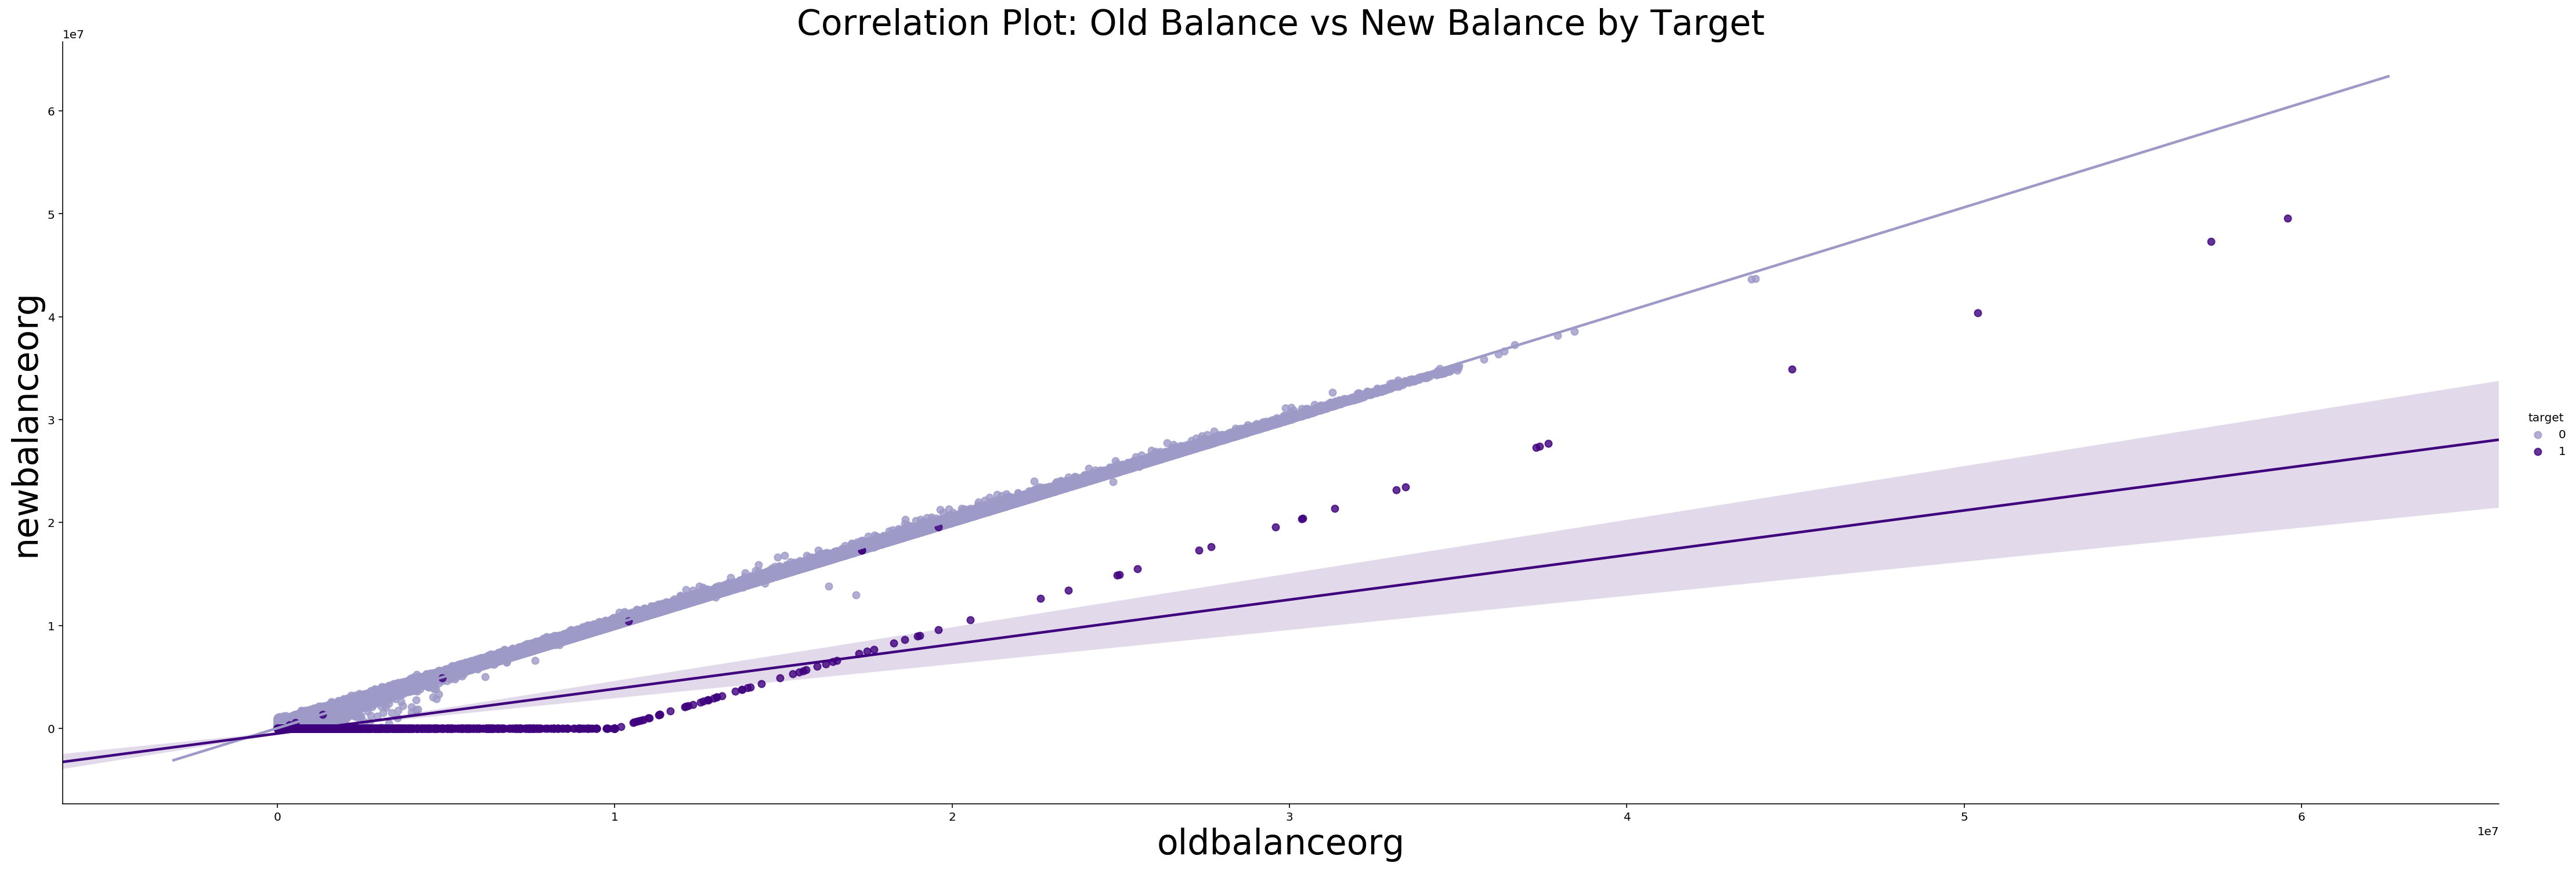

In [27]:
sns.lmplot(x="oldbalanceorig", y="newbalanceorig",  hue='target',
           data=sdf, size=10,aspect=3,
           palette=['#9e9ac8','#3f007d'])
plt.title('Correlation Plot: Old Balance vs New Balance by Target', 
          fontsize=30);
plt.xlabel('oldbalanceorg', fontsize=30)
plt.ylabel('newbalanceorg',fontsize=30);

We can see that the lower trend line is a good sign of a fraudulent transaction. It makes sense. The difference between an accounts original and new balance after fraud would be more significant than after a typical transaction. We can use this information to create a mean transaction amount feature for each original accounts within out datasets. By intuition, this feature should help us isolate transactions with higher accuracy.


##### Encoding Data

I have encoded all categorical features in the dataset. I dropped the "flaggedisfraud" as its a source of a data leak. I also dropped the "Date" after creating  segmented datatime features. I also have one hot encoded the transaction type feature.

In [35]:
sdf.head(4)

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0
8,1,PAYMENT,4024.360,C1265012928,2671.000,0.000,M1176932104,0.000,0.000,0,0
13,1,PAYMENT,11633.760,C1716932897,10127.000,0.000,M801569151,0.000,0.000,0,0


In [36]:
# Encode all object colunms to categorical codes
sdf.type = sdf.type.astype('category').cat.codes
sdf.nameorig = sdf.nameorig.astype('category').cat.codes
sdf.namedest = sdf.namedest.astype('category').cat.codes

# Drop is flagged false column
sdf = sdf.drop('isflaggedfraud', axis=1)

# Concatenate one-hot encoded type features
sdf = pd.concat([sdf,pd.get_dummies(sdf.type, 'type', drop_first=True)], axis=1).drop('type',axis=1)

##### Train-Test Split

In [37]:
# Ruturr dataframes as nupmy arrays
X = sdf.drop('target', axis=1).values
y = sdf.target.values

# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Compute Sample Weights
weights = compute_sample_weight(class_weight='balanced', y=y_train)

### Evaluation Metrics

During the modeling process. I will be using the following accuracy metrics for this binary classification problem.

- AUC ROC
- F1-Score
- Precision
- Recall

The recall is the number of correct results divided by the total number of results. Precision, on the other hand, tells us how many selected items are relevant. Maximizing precision or recall is relatively simple so I also measure the hyperbolic mean between these scores, which would be the F1 scores. Our main metrics will be the Area under the ROC and AUC curve. The ROC is a plot to measure the difference between the TP rate and the FP rate. A higher ROC curve with a larger area under the cure is what I am looking for.

### Benchmark Models

Sometimes, we don't have the appropriate labels to train our supervised models. In these situations, we have to turn to unsupervised methodologies. While unsupervised models usually underperform supervised models, distinct anomaly/thresholding detection algorithms score very well given the lack labels. 

BelowI have calculated the true Contamination Rate of the dataset. I will using this threshold to train our unsupervised thersholding algorithim.

In [38]:
# Set a new default figure size for plotting
rcParams['figure.figsize'] = (30.0, 10.0)

# Print the contaminatin rate of the trainin dataset
contamination_rate = (sdf['target'].value_counts()/sdf['target'].count())[1]
print('Training Contamination Rate:',contamination_rate)

Training Contamination Rate: 0.0012730604688005885


<a id='envolope'></a>
##### Elliptic Envelope

Elliptic Envelope model goes about creating an ellipse around our data's hyperplane and segmenting out outliers by placing a boundary around the data. The algorithm assumes that your data follows a Gaussian distribution as the model take bivariate samples of the dataset when calculating this boundary.

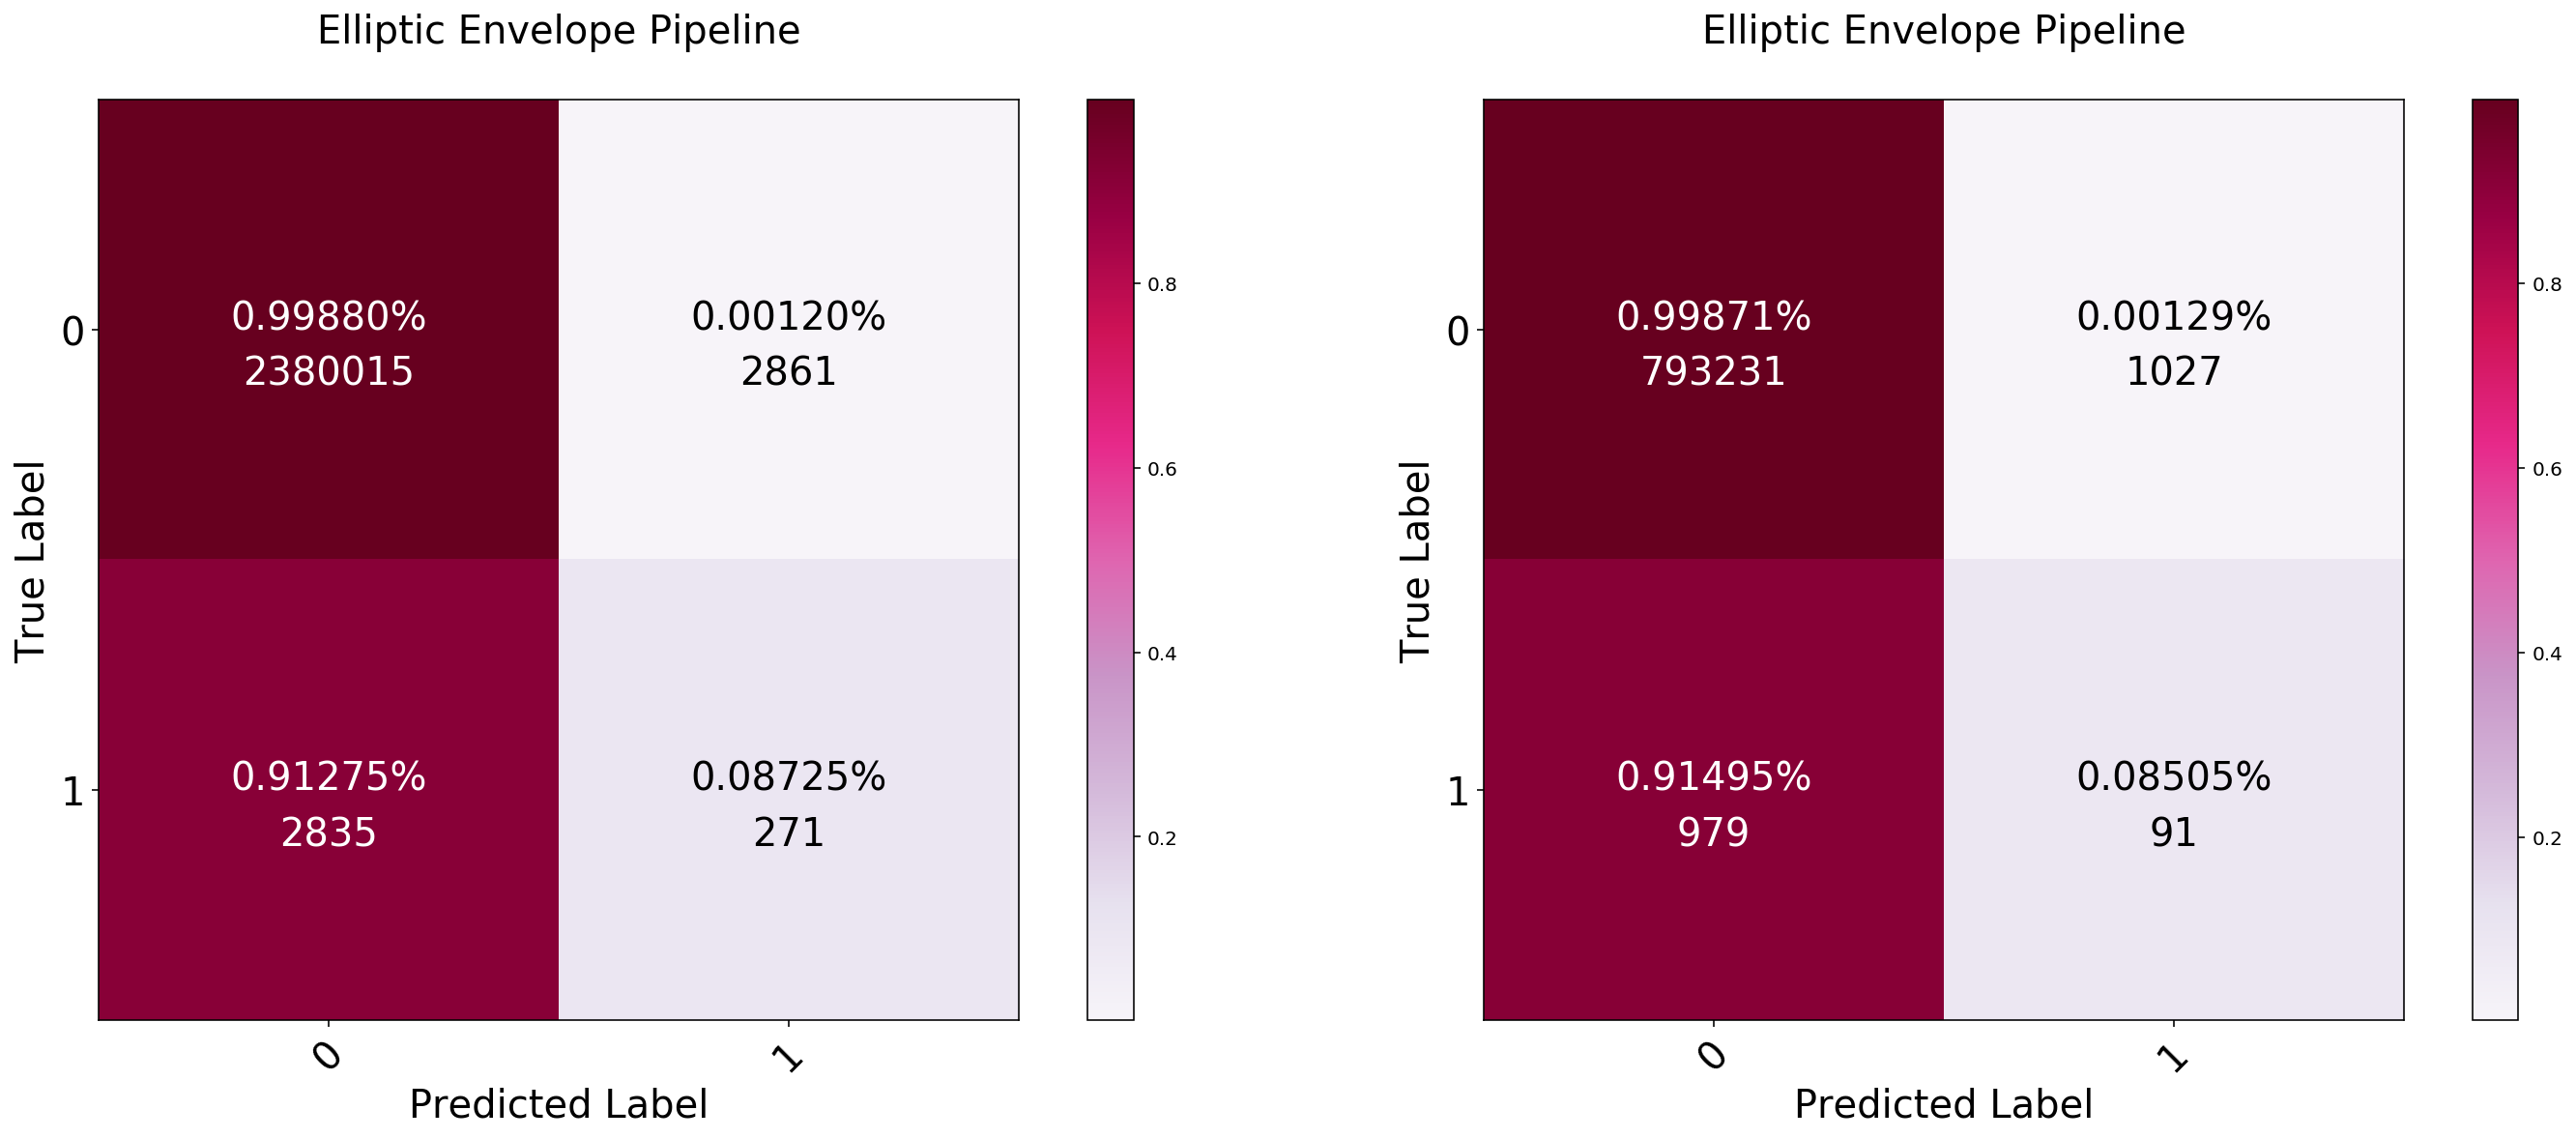

In [45]:
# Build Elliptic Envelope Pipeline
ee_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            EllipticEnvelope(
                                contamination=contamination_rate))

# Run some cross validation on the pipeline
ee_scores = cross_validate(ee_pipeline,X_train,
                           target_to_anon(y_train),
                           cv=5, 
                           scoring=['accuracy','precision','recall',
                                    'f1','roc_auc'],)

# Fit the pipline and return predictions
ee_pipeline.fit(X_train,y_train)
ee_pred = ee_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(ee_pipeline, 'Models/fraud_ee_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_anomoly(model=ee_pipeline, classes=[0,1], 
                      name = 'Elliptic Envelope Pipeline',
                      train_x=X_train,
                      test_x=X_test,
                      train_y=y_train, test_y=y_test,
                      cmap= plt.cm.PuRd)

In [47]:
# View Elliptic Envolope's model scores
ee_score_df = pd.DataFrame(ee_scores).T
ee_score_df['Mean'] = ee_score_df.mean(axis=1)
ee_score_df['Mean']

fit_time          169.151
score_time          1.101
test_accuracy       0.998
train_accuracy      0.998
test_precision      0.999
train_precision     0.999
test_recall         0.999
train_recall        0.999
test_f1             0.999
train_f1            0.999
test_roc_auc        0.817
train_roc_auc       0.817
Name: Mean, dtype: float64

#### Nearest Neighbours Regression

I will be using a Support Vector Machine using an RBF kernel as my model benchmark. The results of the supervised model can be seen below. The sample weights to resolve the class imbalance are passed through the model as a dictionary using the `fit params` parameeter. The weights are applied during models training.

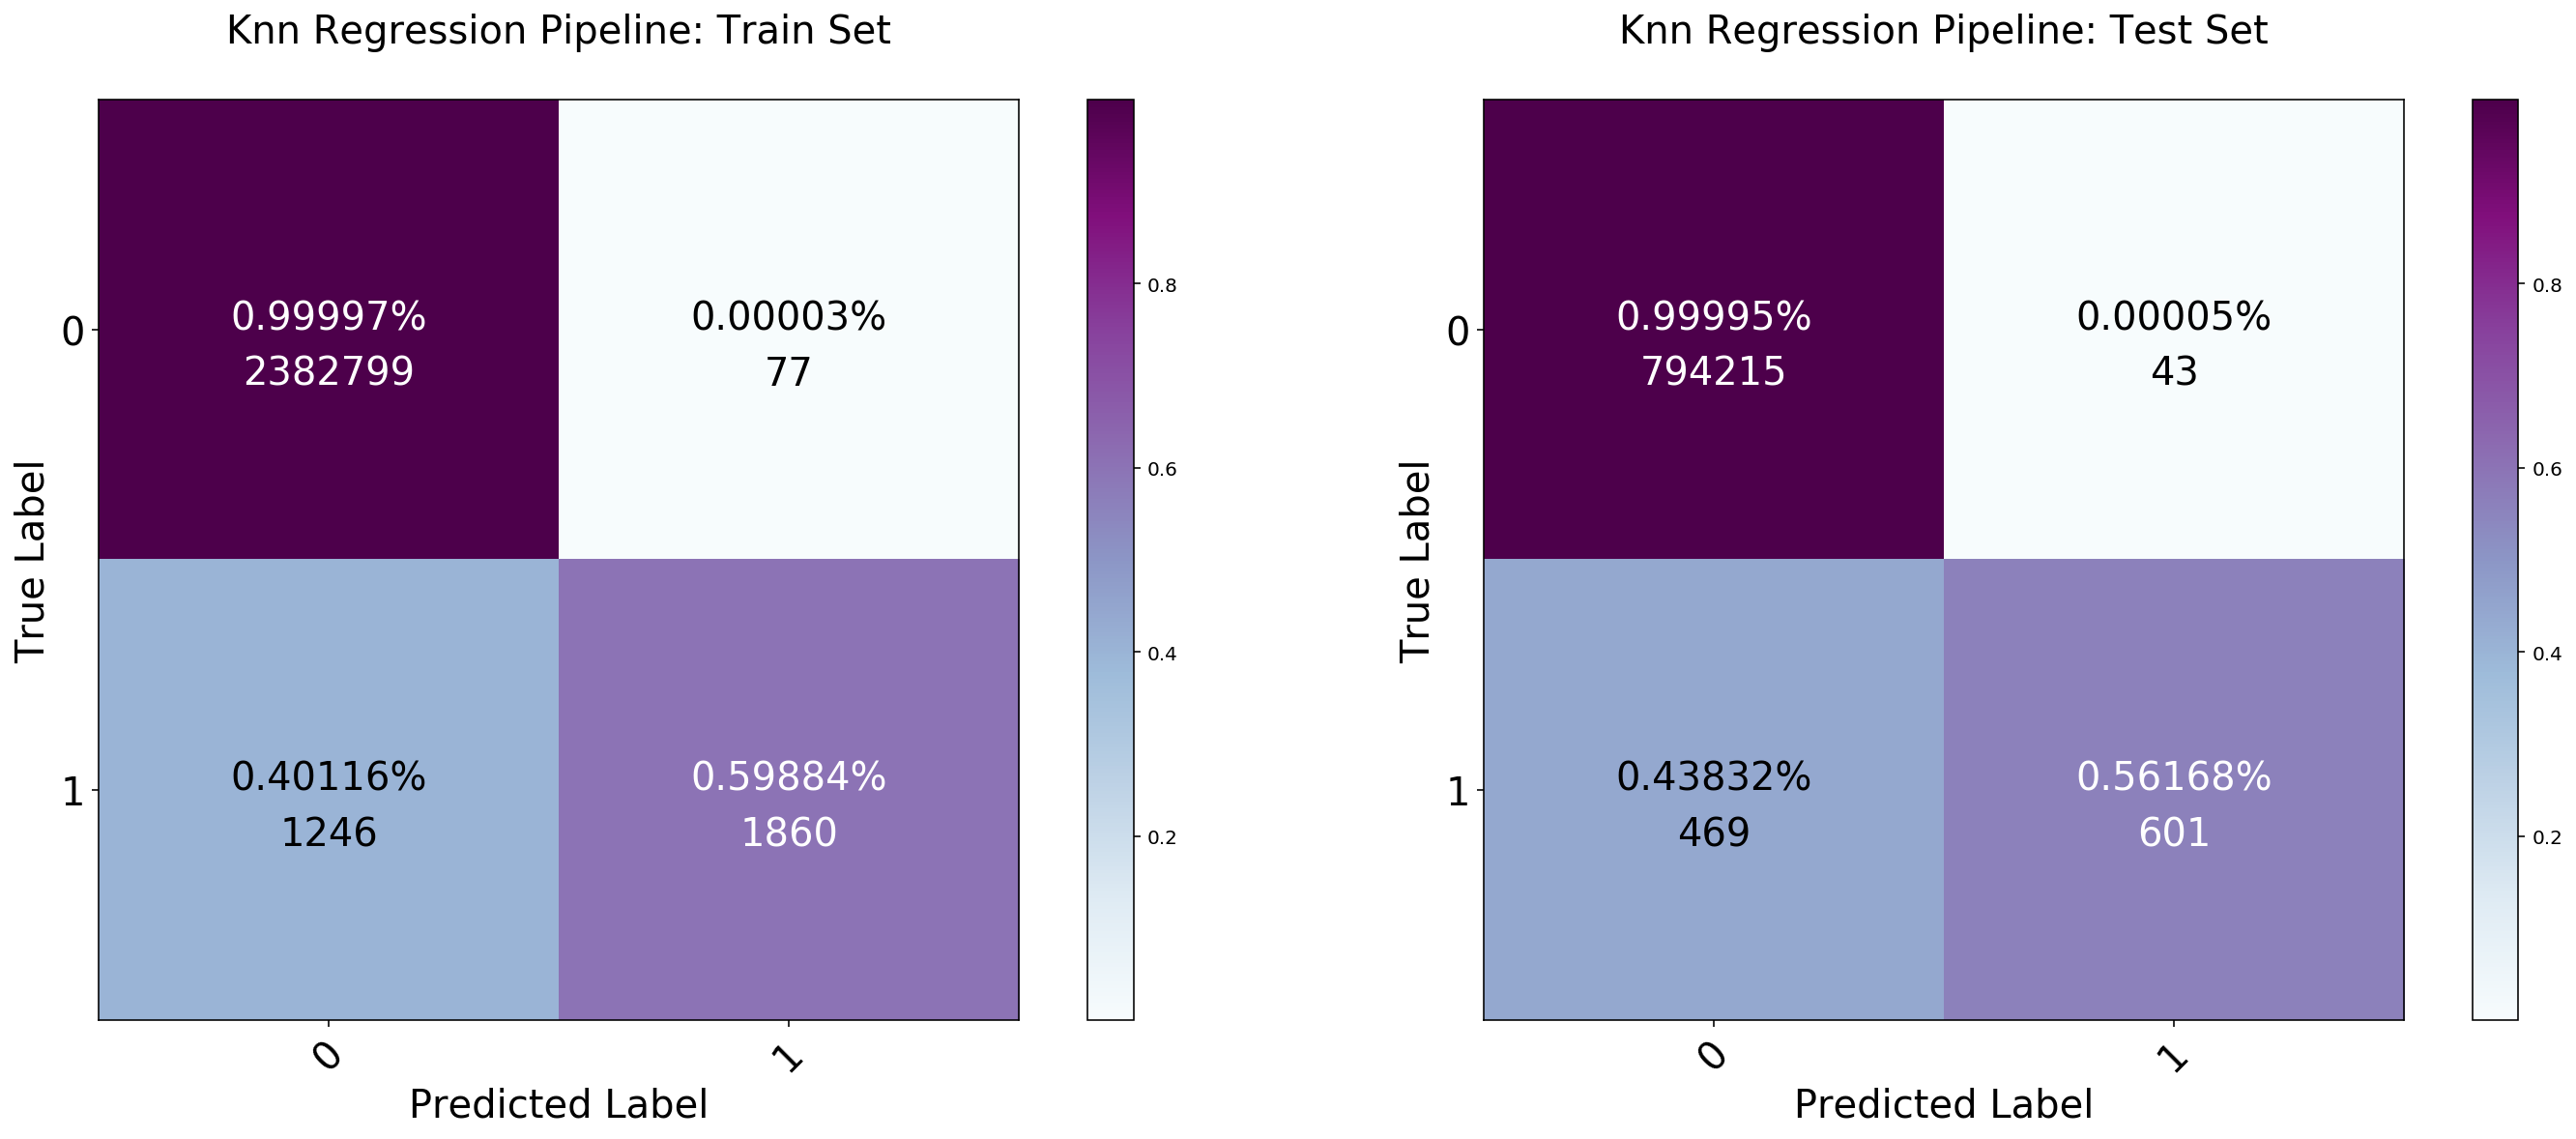

In [6]:
# Build Logistic Regression Pipeline
knn_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            KNeighborsClassifier(n_jobs=-1))
# Run some cross validation on the pipeline
knn_scores = cross_validate(knn_pipeline, X_train, y_train, cv=5, 
                           scoring=['accuracy','precision','recall',
                                    'f1','roc_auc'],
                           n_jobs=4)

# Fit the pipline and return predictions
knn_pipeline.fit(X_train,y_train)
knn_pred = knn_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(knn_pipeline, 'Models/fraud_knn_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_normal(model=knn_pipeline, classes=[0,1], 
                      name = 'KNN Regression Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                       cmap= plt.cm.BuPu)


In [34]:
# View KNN model Scores
knn_score_df = pd.DataFrame(knn_scores).T
knn_score_df['Mean'] = knn_score_df.mean(axis=1)
knn_score_df['Mean']

fit_time           40.731
score_time        525.571
test_accuracy       0.999
train_accuracy      0.999
test_precision      0.931
train_precision     0.960
test_recall         0.555
train_recall        0.592
test_f1             0.695
train_f1            0.732
test_roc_auc        0.843
train_roc_auc       1.000
Name: Mean, dtype: float64

### Unsupervised Models

The two benchmark models above score well. Next, I will first be reviewing a couple of unsupervised anomaly detection models, that can be used to locates fraudulent transactions within the data by treating cases of fraud as anomalies. I will later move on to superised models.


##### Isolation Forest

In the context of this problem, we can also treat causes for fraud as anomalies. The isolation forest algorithm is a random forest of decision trees that have been modified to detect abnormalities in the data. The algorithm generates an ensemble of decisions tree,  which  use one single feature with the data during their training. Each tree randomly split on a value between the feature's max and min value.  The goal of the individual tree is to isolate each value its splits on into a node.

After the forest has finished training, the model measures the number of splits it took to push the anomalies out of the tree. For a majority of anomalies, it is common for its value to be segmented early on. On average anomalies will have a  shorter depth in across tree. Finally, the isolation forest uses a contamination rate after ranking the max depth of each data point to label anomalies. The algorithm performs pretty well given no labels. 

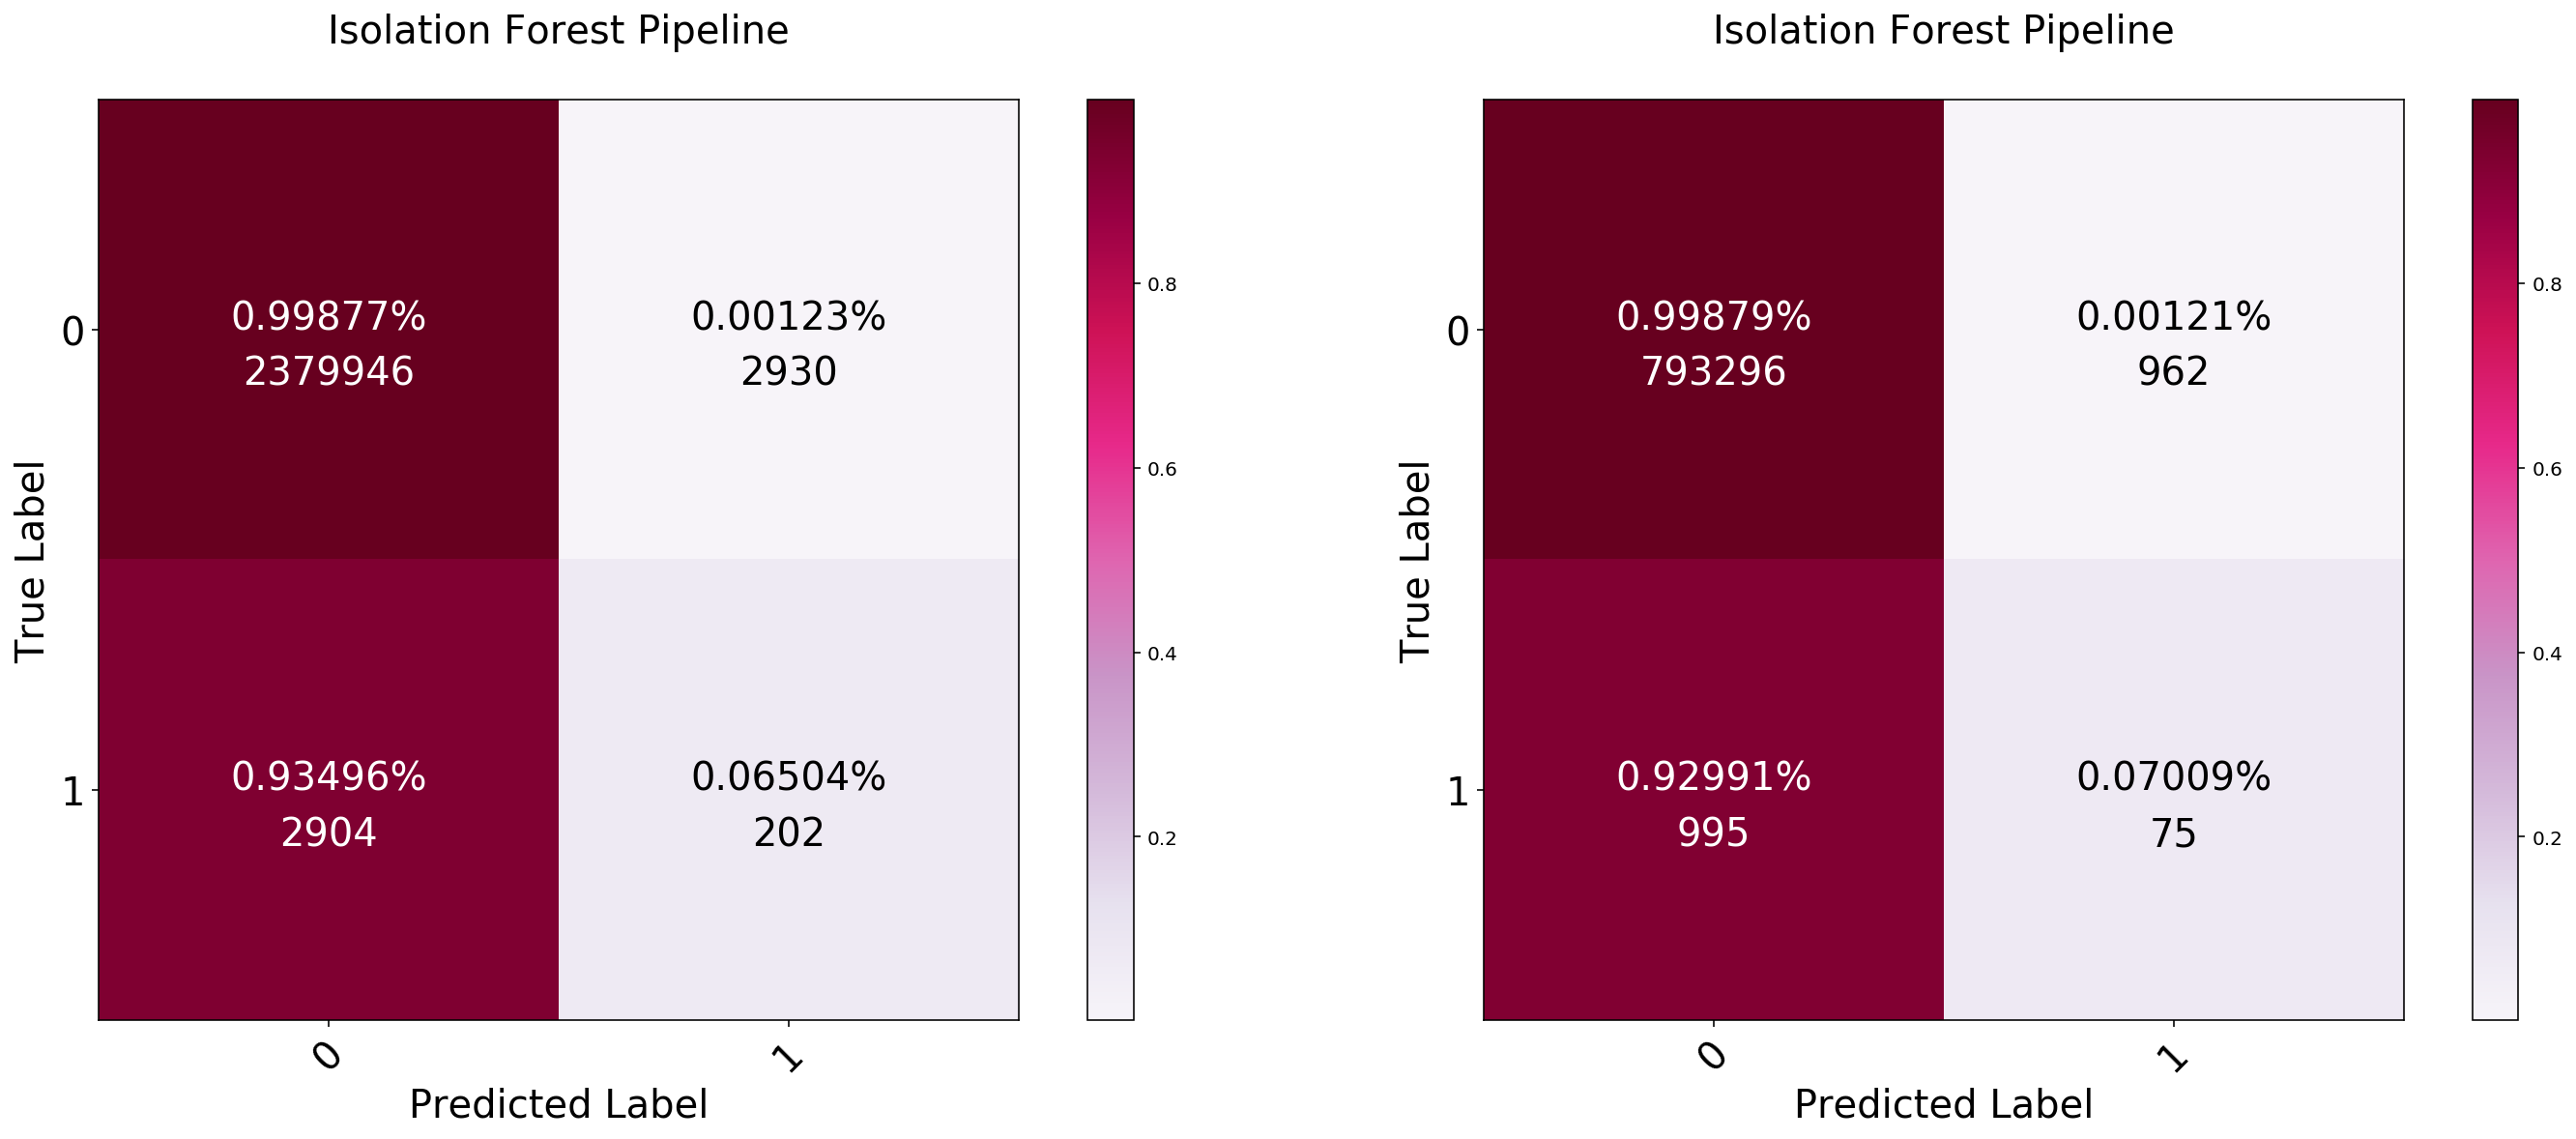

In [43]:
# Build an Isolation Forest Pipeline
if_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            IsolationForest(n_jobs=-1,
                                contamination=contamination_rate))

# Run some cross validation on the pipeline
if_scores = cross_validate(if_pipeline,X_train,
                           target_to_anon(y_train),
                           cv=5, 
                           scoring=['accuracy','precision','recall',
                                    'f1','roc_auc'],
                           fit_params={'isolationforest__sample_weight':weights})

# Fit the pipline and return predictions
if_pipeline.fit(X_train,y_train, **{'isolationforest__sample_weight':weights})
if_pred = if_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(if_pipeline, 'Models/fraud_if_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_anomoly(model=if_pipeline, classes=[0,1], 
                      name = 'Isolation Forest Pipeline',
                      train_x=X_train,
                      test_x=X_test,
                      train_y=y_train, test_y=y_test,
                       cmap= plt.cm.PuRd)

In [44]:
# View if model Scores
if_score_df = pd.DataFrame(if_scores).T
if_score_df['Mean'] = if_score_df.mean(axis=1)
if_score_df['Mean']

fit_time          78.906
score_time        58.845
test_accuracy      0.998
train_accuracy     0.998
test_precision     0.999
train_precision    0.999
test_recall        0.999
train_recall       0.999
test_f1            0.999
train_f1           0.999
test_roc_auc       0.865
train_roc_auc      0.866
Name: Mean, dtype: float64

The isolation forest algorithim scores rather well on this problem, its roc_auc score is 0.86~. Given that the model does not use the target labels during training, this is impressive. Other alogrithims such as Meanshift, DBSCAN, and HDBSCAN only scored around just above random (0.50 to 0.55).

# <a id='dtc'></a>
### Supervised Models
Decision Tree are popular models as they are easy to intrepret to the humman eye. This makes them more advantagous to use compare to the KNN model. The Decision tree will split the data based on this gini coefficent and make the apporiate split in the data that maximized the our roc auc score.

##### XG Boost

XG Boost is a gradient boosting algorithm that contains additional optimizations under the hood. This algorithm has been dominant in the competitive machine learning space in the majority of the last decade.

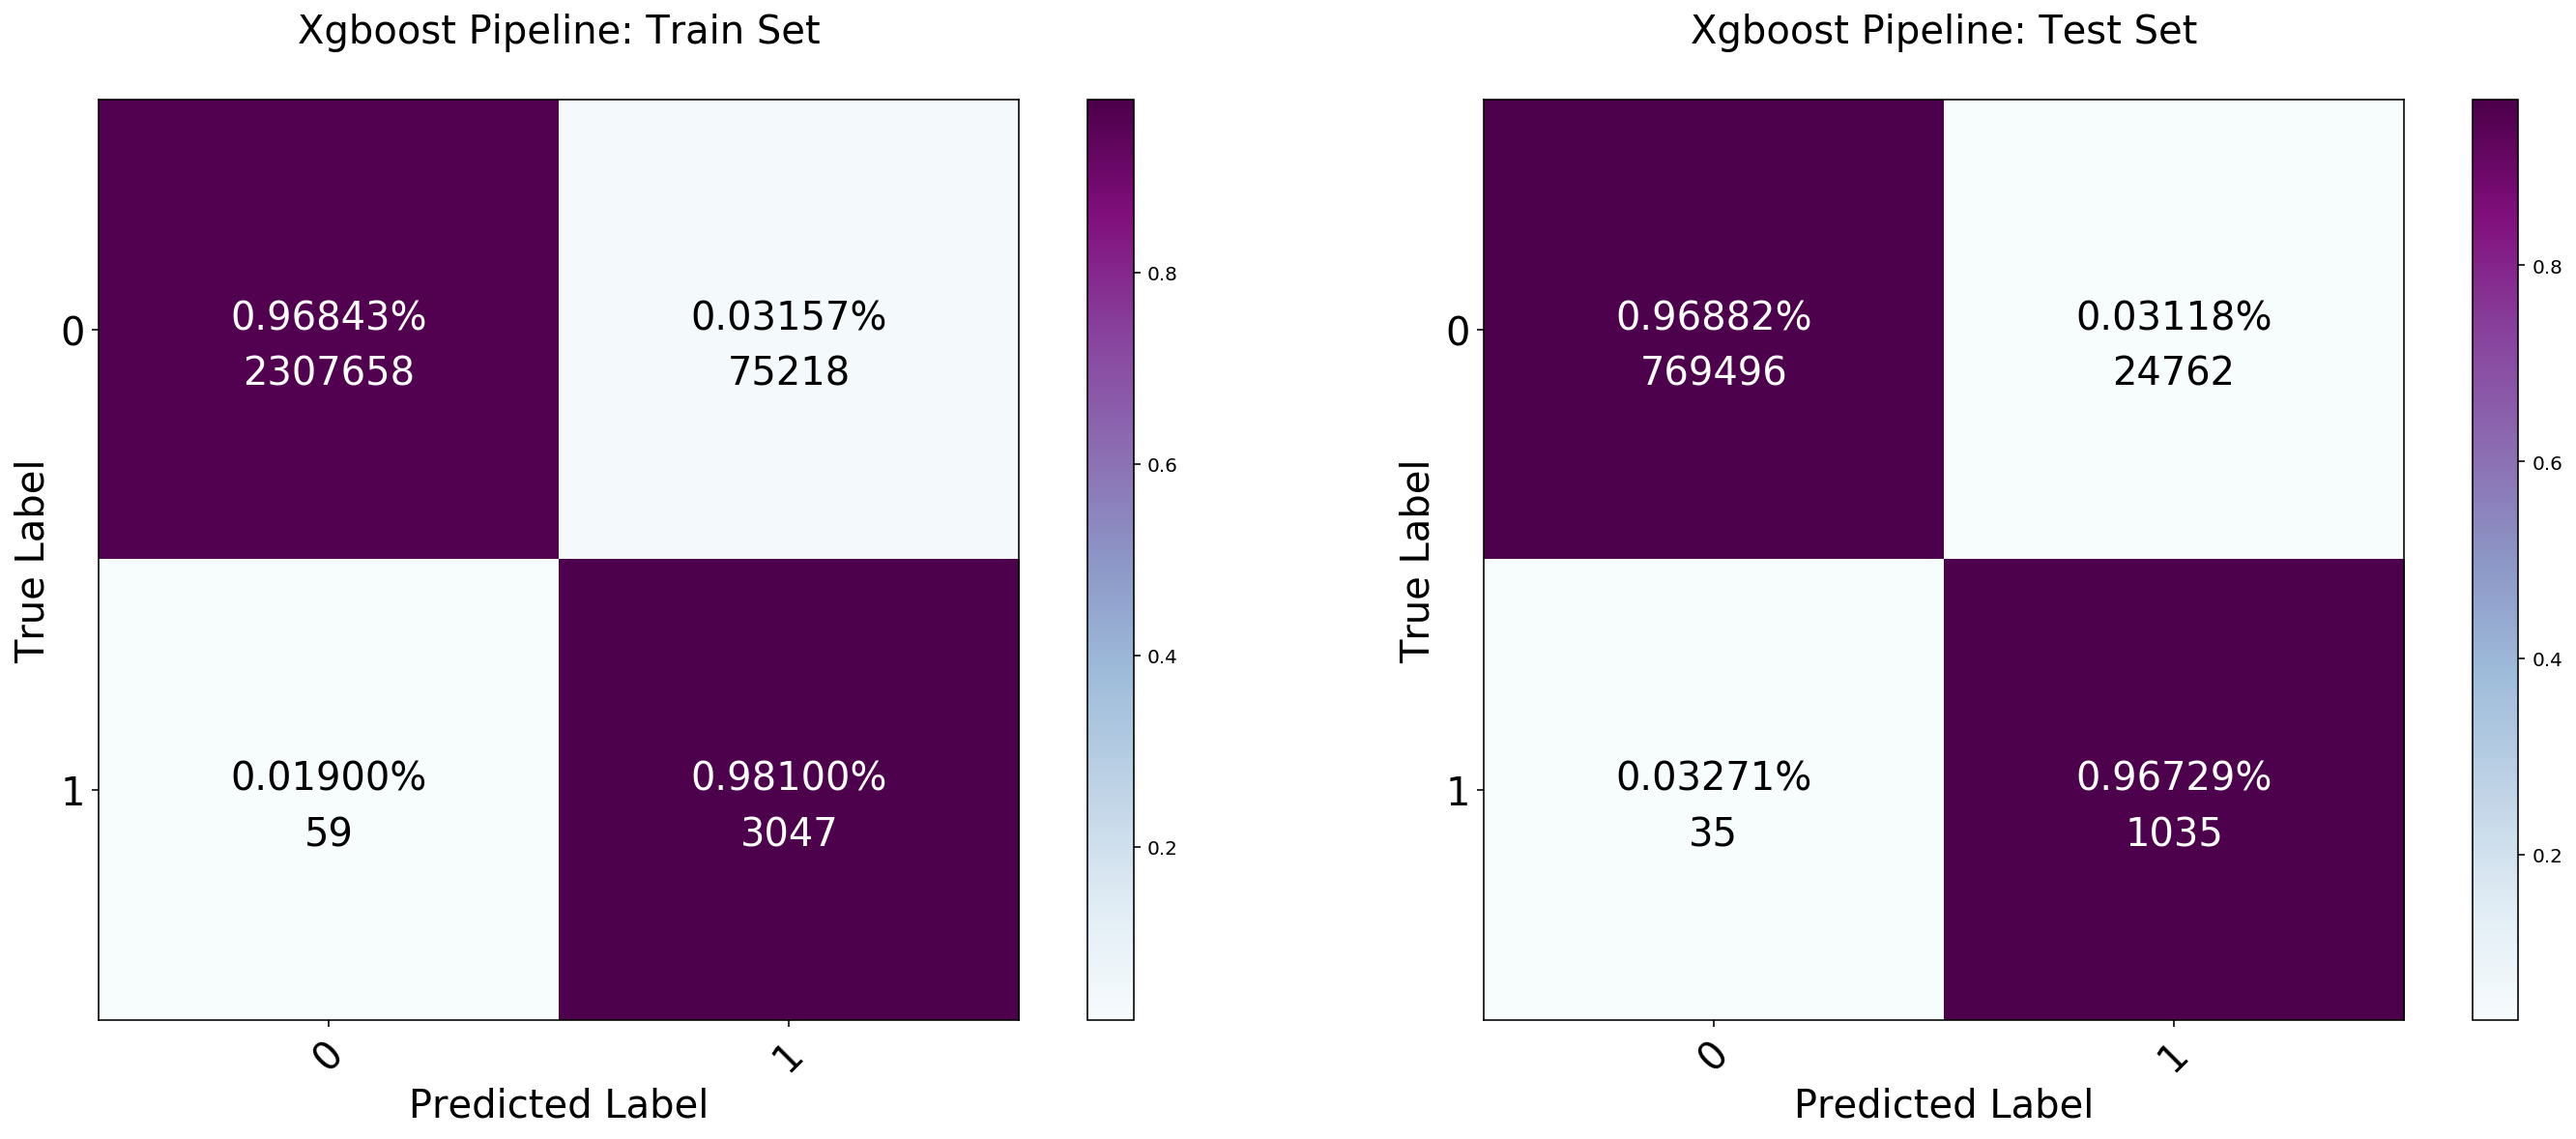

In [71]:
# Build Support Vector Machien Pipeline
xgb_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                             XGBClassifier(n_jobs=-1))
# Run some cross validation on the pipeline
xgb_scores = cross_validate(xgb_pipeline, X_train, y_train, cv=5, 
                           scoring=['accuracy','precision','recall',
                                    'f1','roc_auc'],
                           fit_params={'xgbclassifier__sample_weight':weights})

# Fit the pipline and return predictions
xgb_pipeline.fit(X_train,y_train, **{'xgbclassifier__sample_weight':weights})
xgb_pred = xgb_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(xgb_pipeline, 'Models/fraud_xgb_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_normal(model=xgb_pipeline, classes=[0,1], 
                      name = 'XGBoost Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)


In [72]:
# View xgb model Scores
xgb_score_df = pd.DataFrame(xgb_scores).T
xgb_score_df['Mean'] = xgb_score_df.mean(axis=1)
xgb_score_df['Mean']

fit_time          94.792
score_time         2.652
test_accuracy      0.969
train_accuracy     0.969
test_precision     0.039
train_precision    0.040
test_recall        0.969
train_recall       0.983
test_f1            0.075
train_f1           0.076
test_roc_auc       0.996
train_roc_auc      0.998
Name: Mean, dtype: float64

Here we see a trade off between the XGBoost model and the Random Forest model. The Random Forest Model has a better f1 and roc_auc score. Yet the model is prone to assigning more false positives then our XGBoost model. Lets test both pipeline on the holdout data we and see if the performance is consistent.

##### Dense Neural Network

In [108]:
rfr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            RandomForestClassifier(n_jobs=-1))
rfr_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'pca', 'standardscaler', 'randomforestclassifier', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [103]:
xgb_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                             XGBClassifier(n_jobs=-1))

xgb_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'pca', 'standardscaler', 'xgbclassifier', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__nthread', 'xgbclassifier__objective', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__seed', 'xgbclassifier__silent', 'xgbclassifier__subsample'])

Epoch 1/5
2385982/2385982 [==============================] - 163s 68us/step - loss: 0.3317 - acc: 0.9353
Epoch 2/5
2385982/2385982 [==============================] - 161s 67us/step - loss: 1.1440 - acc: 0.9336
Epoch 3/5
2385982/2385982 [==============================] - 159s 67us/step - loss: 2.1597 - acc: 0.9731
Epoch 4/5
2385982/2385982 [==============================] - 158s 66us/step - loss: 2.0500 - acc: 0.9780
Epoch 5/5
795328/795328 [==============================] - 24s 30us/step


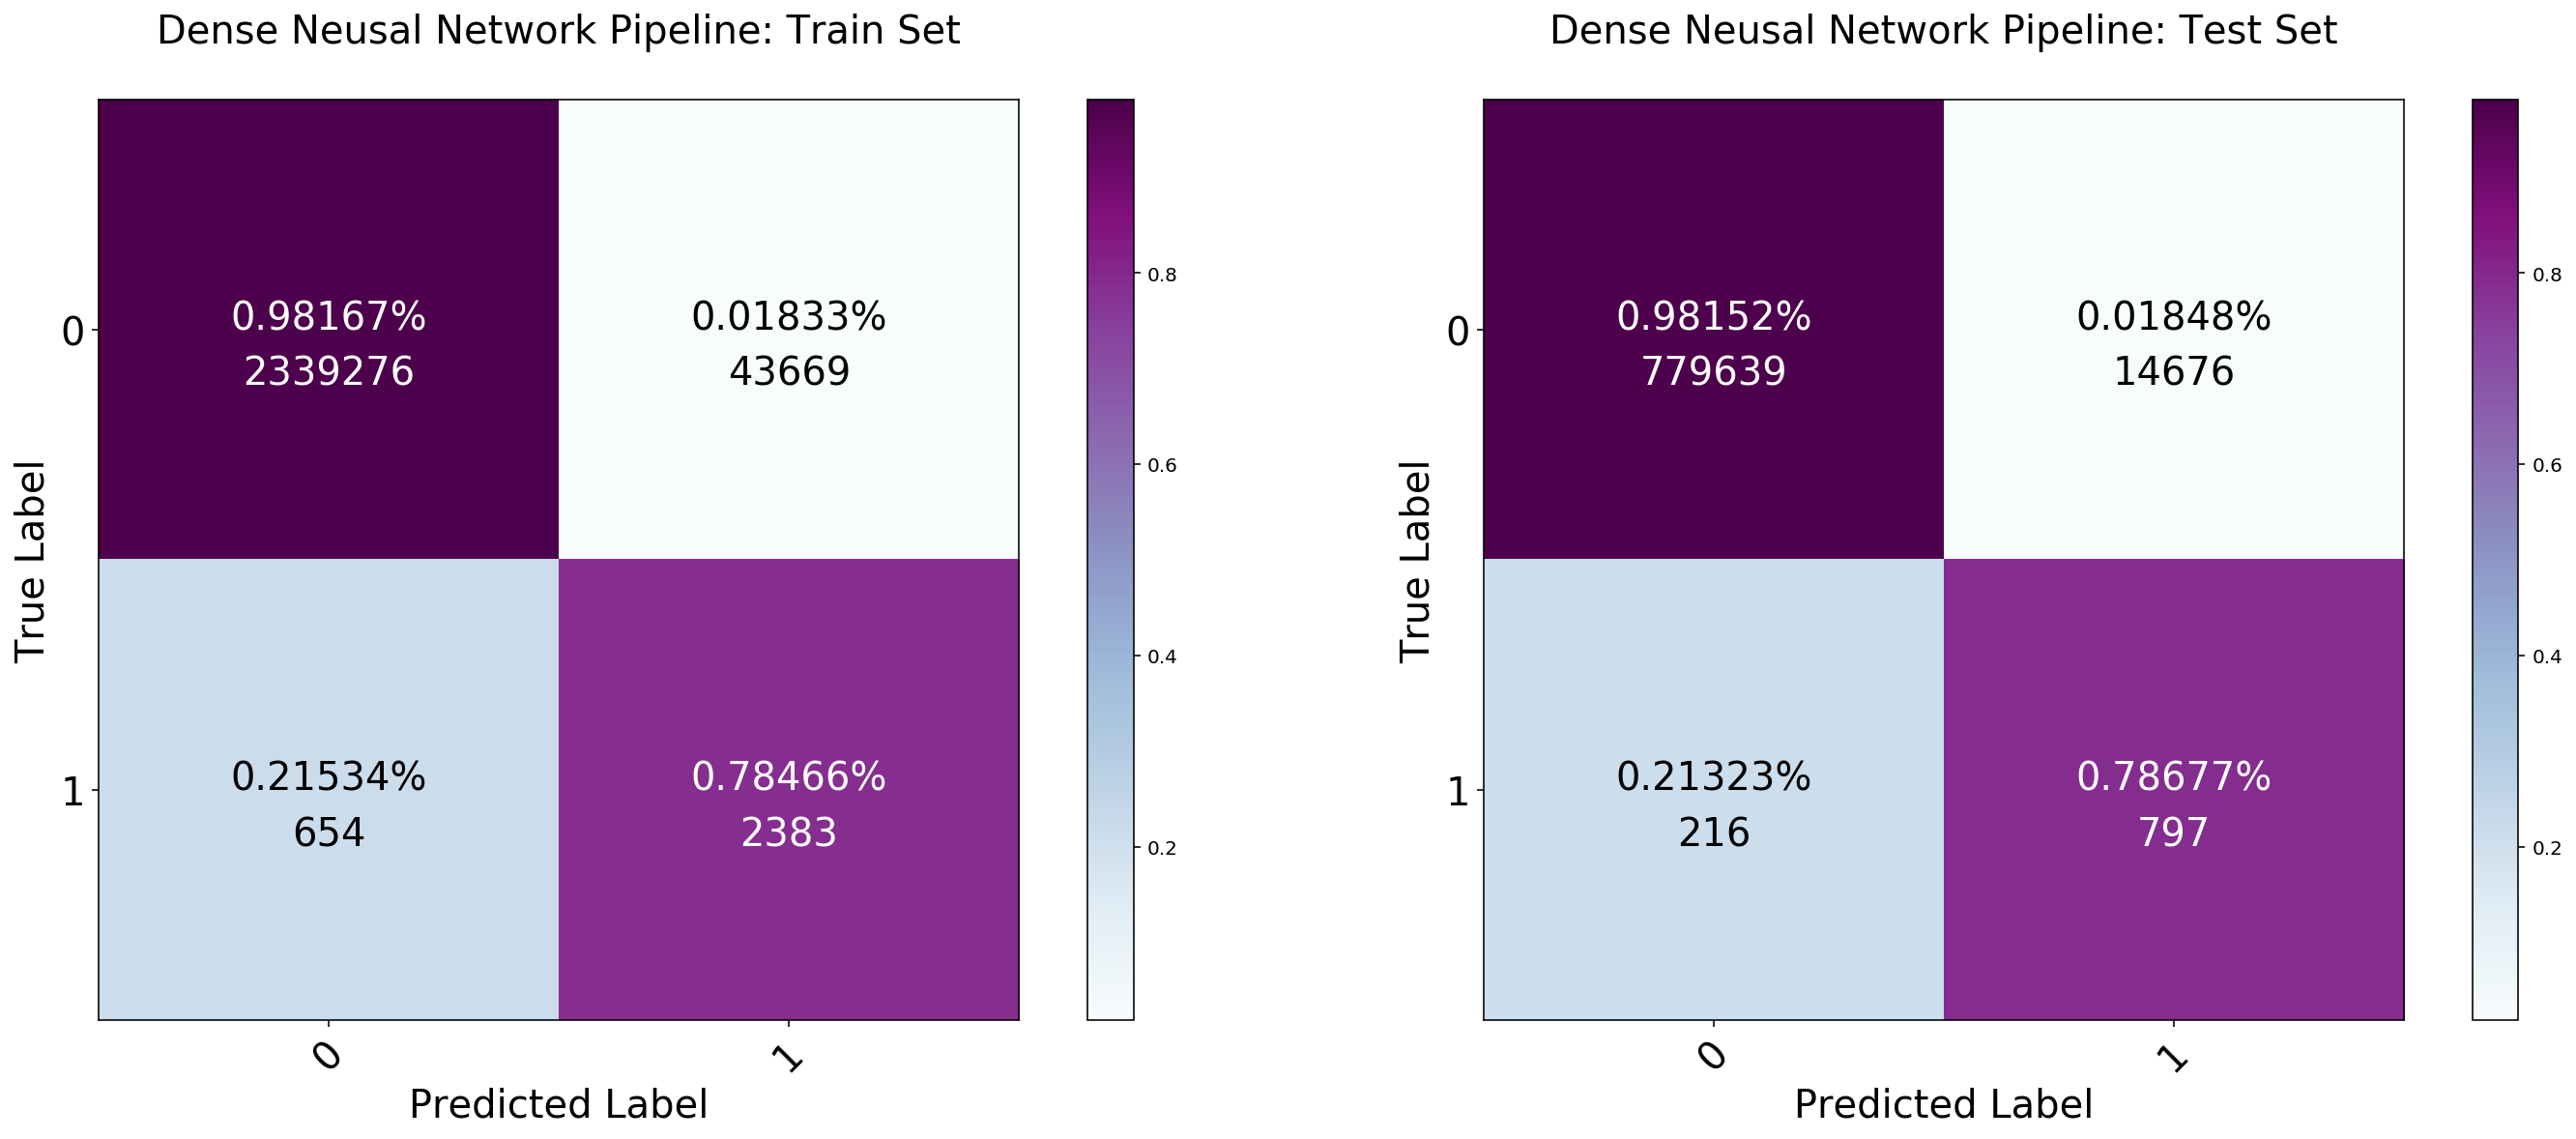

In [127]:
def create_model():
    model = Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(10,),
                          name='Dense_Layer_1'))
    model.add(layers.Dense(64, activation='relu',
                          name='Dense_Layer_2'))
    model.add(layers.Dense(1, activation='sigmoid',
                          name='Softmax_Layer'))
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
    return model

# 
nn_model = KerasClassifier(build_fn=create_model, 
                           nb_epoch=10, verbose=1)

nn_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(),
                             nn_model)


# nn_scores = cross_validate(nn_pipeline, X_train, y_train, cv=5, 
#                            scoring=['accuracy','precision','recall',
#                                     'f1','roc_auc'],
#                            fit_params={'kerasclassifier__sample_weight':weights})

nn_pipeline.fit(X_train,y_train,
               **{'kerasclassifier__sample_weight':weights,
                  'kerasclassifier__nb_epoch':5})

plot_confusion_normal(model=nn_pipeline, classes=[0,1], 
                      name = 'Dense Neusal Network Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)



Epoch 1/5
2385982/2385982 [==============================] - 163s 68us/step - loss: 0.0034 - acc: 0.9994
Epoch 2/5
2385982/2385982 [==============================] - 156s 65us/step - loss: 0.0028 - acc: 0.9995
Epoch 3/5
2385982/2385982 [==============================] - 164s 69us/step - loss: 0.0027 - acc: 0.9995
Epoch 4/5
2385982/2385982 [==============================] - 163s 68us/step - loss: 0.0026 - acc: 0.9995
Epoch 5/5
795328/795328 [==============================] - 26s 32us/step


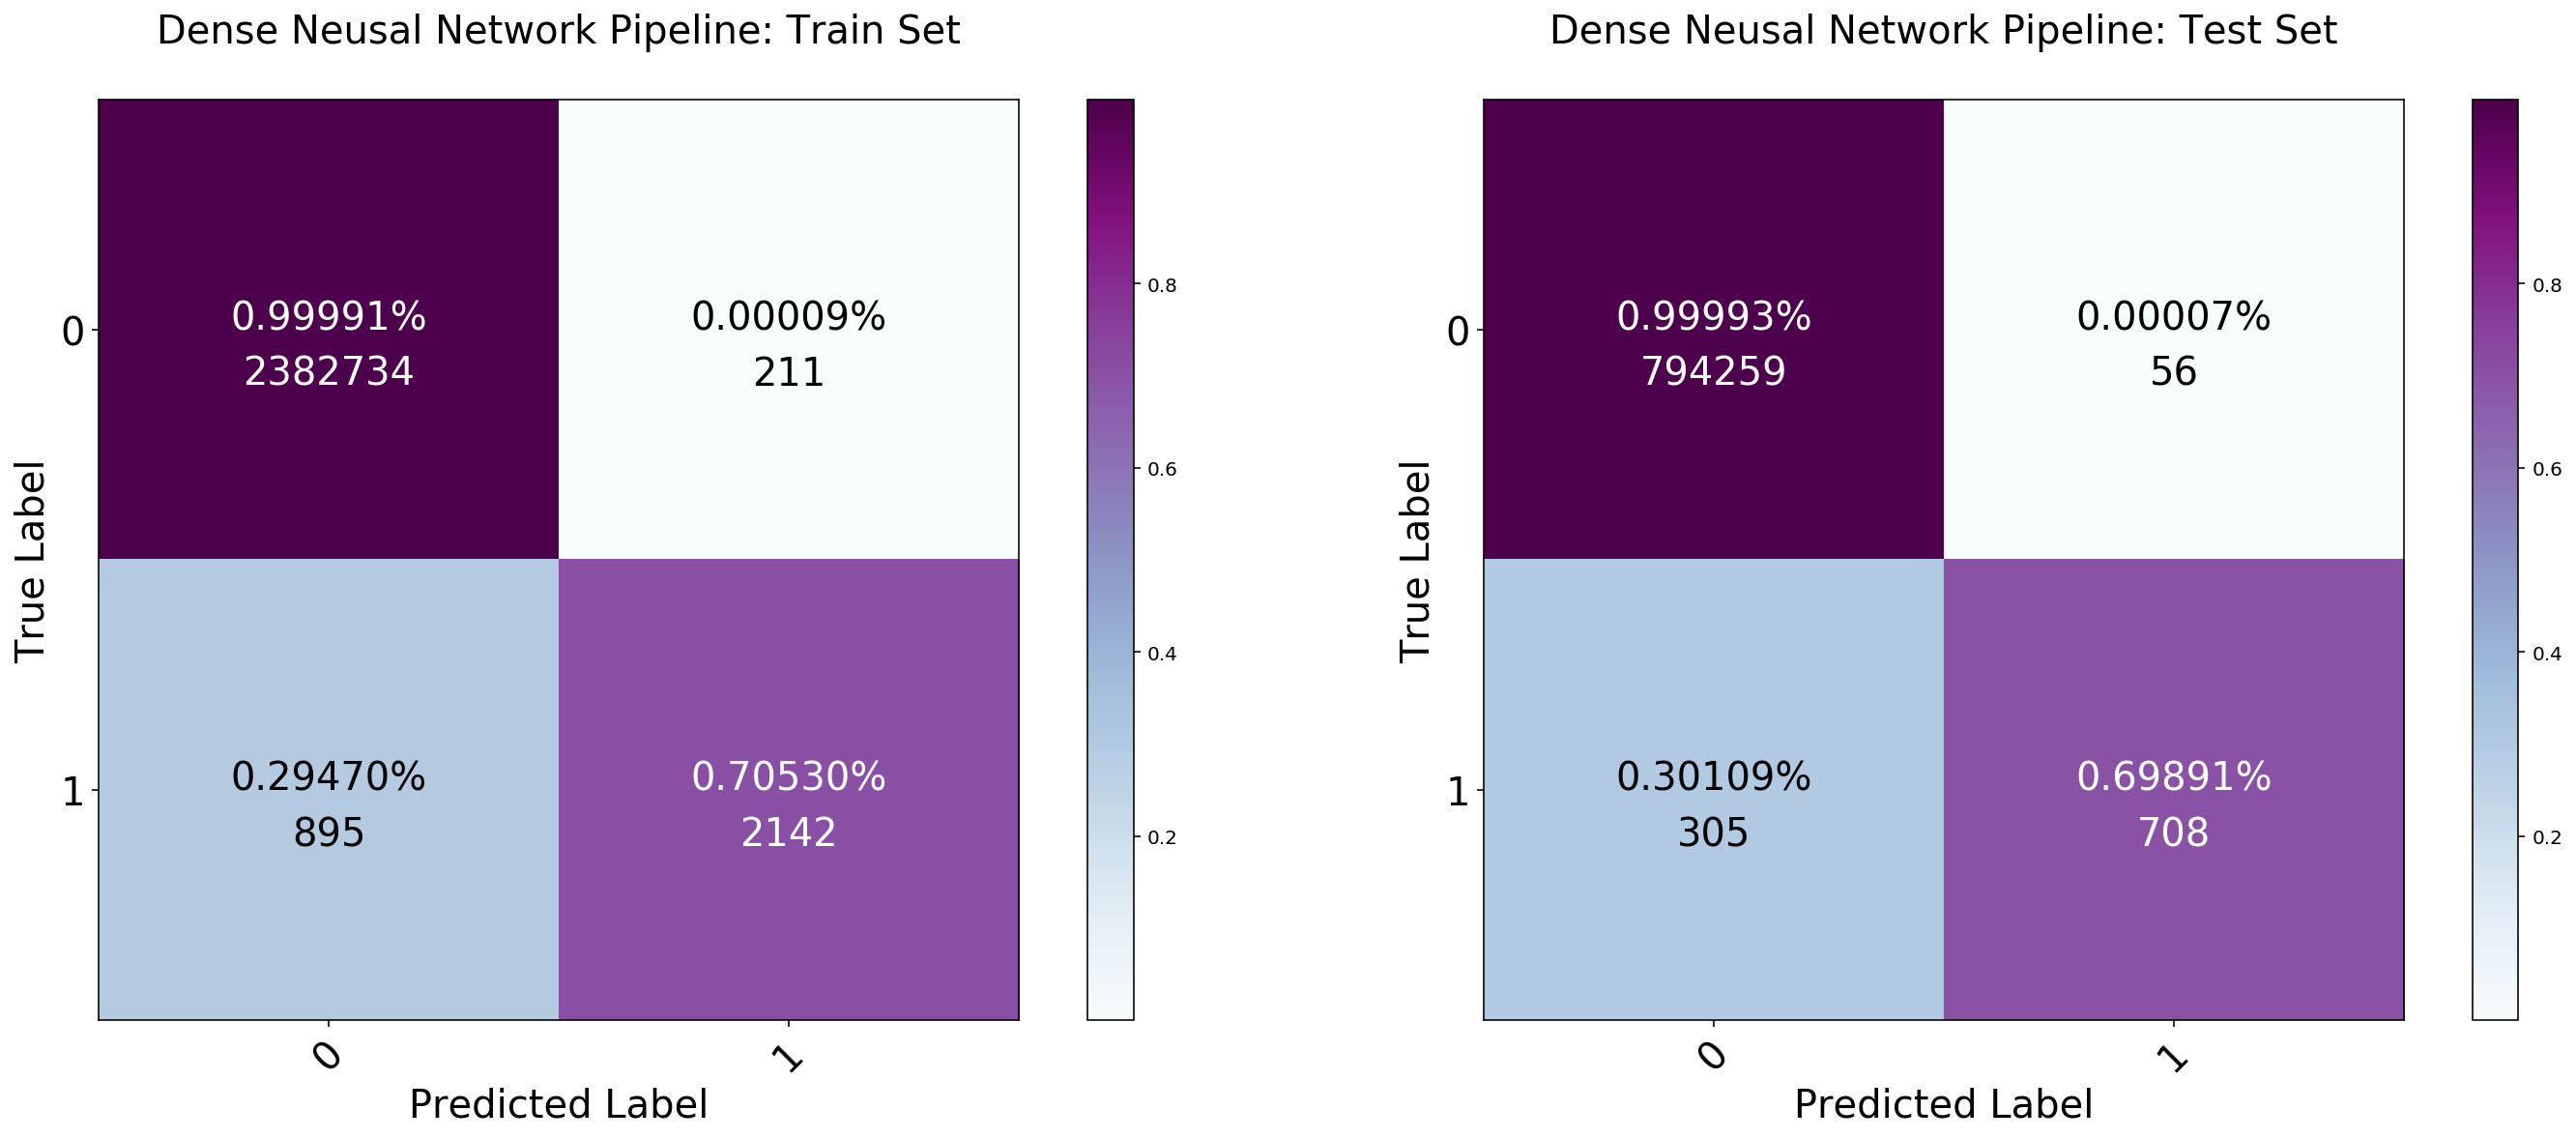

In [128]:
def create_model():
    model = Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(10,),
                          name='Dense_Layer_1'))
    model.add(layers.Dense(64, activation='relu',
                          name='Dense_Layer_2'))
    model.add(layers.Dense(1, activation='sigmoid',
                          name='Softmax_Layer'))
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
    return model

# 
nn_model = KerasClassifier(build_fn=create_model, 
                           nb_epoch=10, verbose=1)

nn_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(),
                             nn_model)


# nn_scores = cross_validate(nn_pipeline, X_train, y_train, cv=5, 
#                            scoring=['accuracy','precision','recall',
#                                     'f1','roc_auc'],)

nn_pipeline.fit(X_train,y_train, **{'kerasclassifier__nb_epoch':5})

plot_confusion_normal(model=nn_pipeline, classes=[0,1], 
                      name = 'Dense Neusal Network Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)



In [ ]:
nn_pipeline.get_params().keys()

In [ ]:
nn_model.get_params().keys()

In [115]:
# View nn model Scores
nn_score_df = pd.DataFrame(nn_scores).T
nn_score_df['Mean'] = nn_score_df.mean(axis=1)
nn_score_df['Mean']

fit_time          114.214
score_time         60.525
test_accuracy       0.999
train_accuracy      0.999
test_precision      0.949
train_precision     0.947
test_recall         0.610
train_recall        0.612
test_f1             0.741
train_f1            0.741
test_roc_auc        0.987
train_roc_auc       0.988
Name: Mean, dtype: float64

##### Random Forest Classifier

The scores of decision tree can change dermaticaly the often we run the model. Therefore using random forest model with give us the benefits of the decision tree with the add stabaility of an ensemble to stabilize our results. You see that I did an model with and without PCA information again.

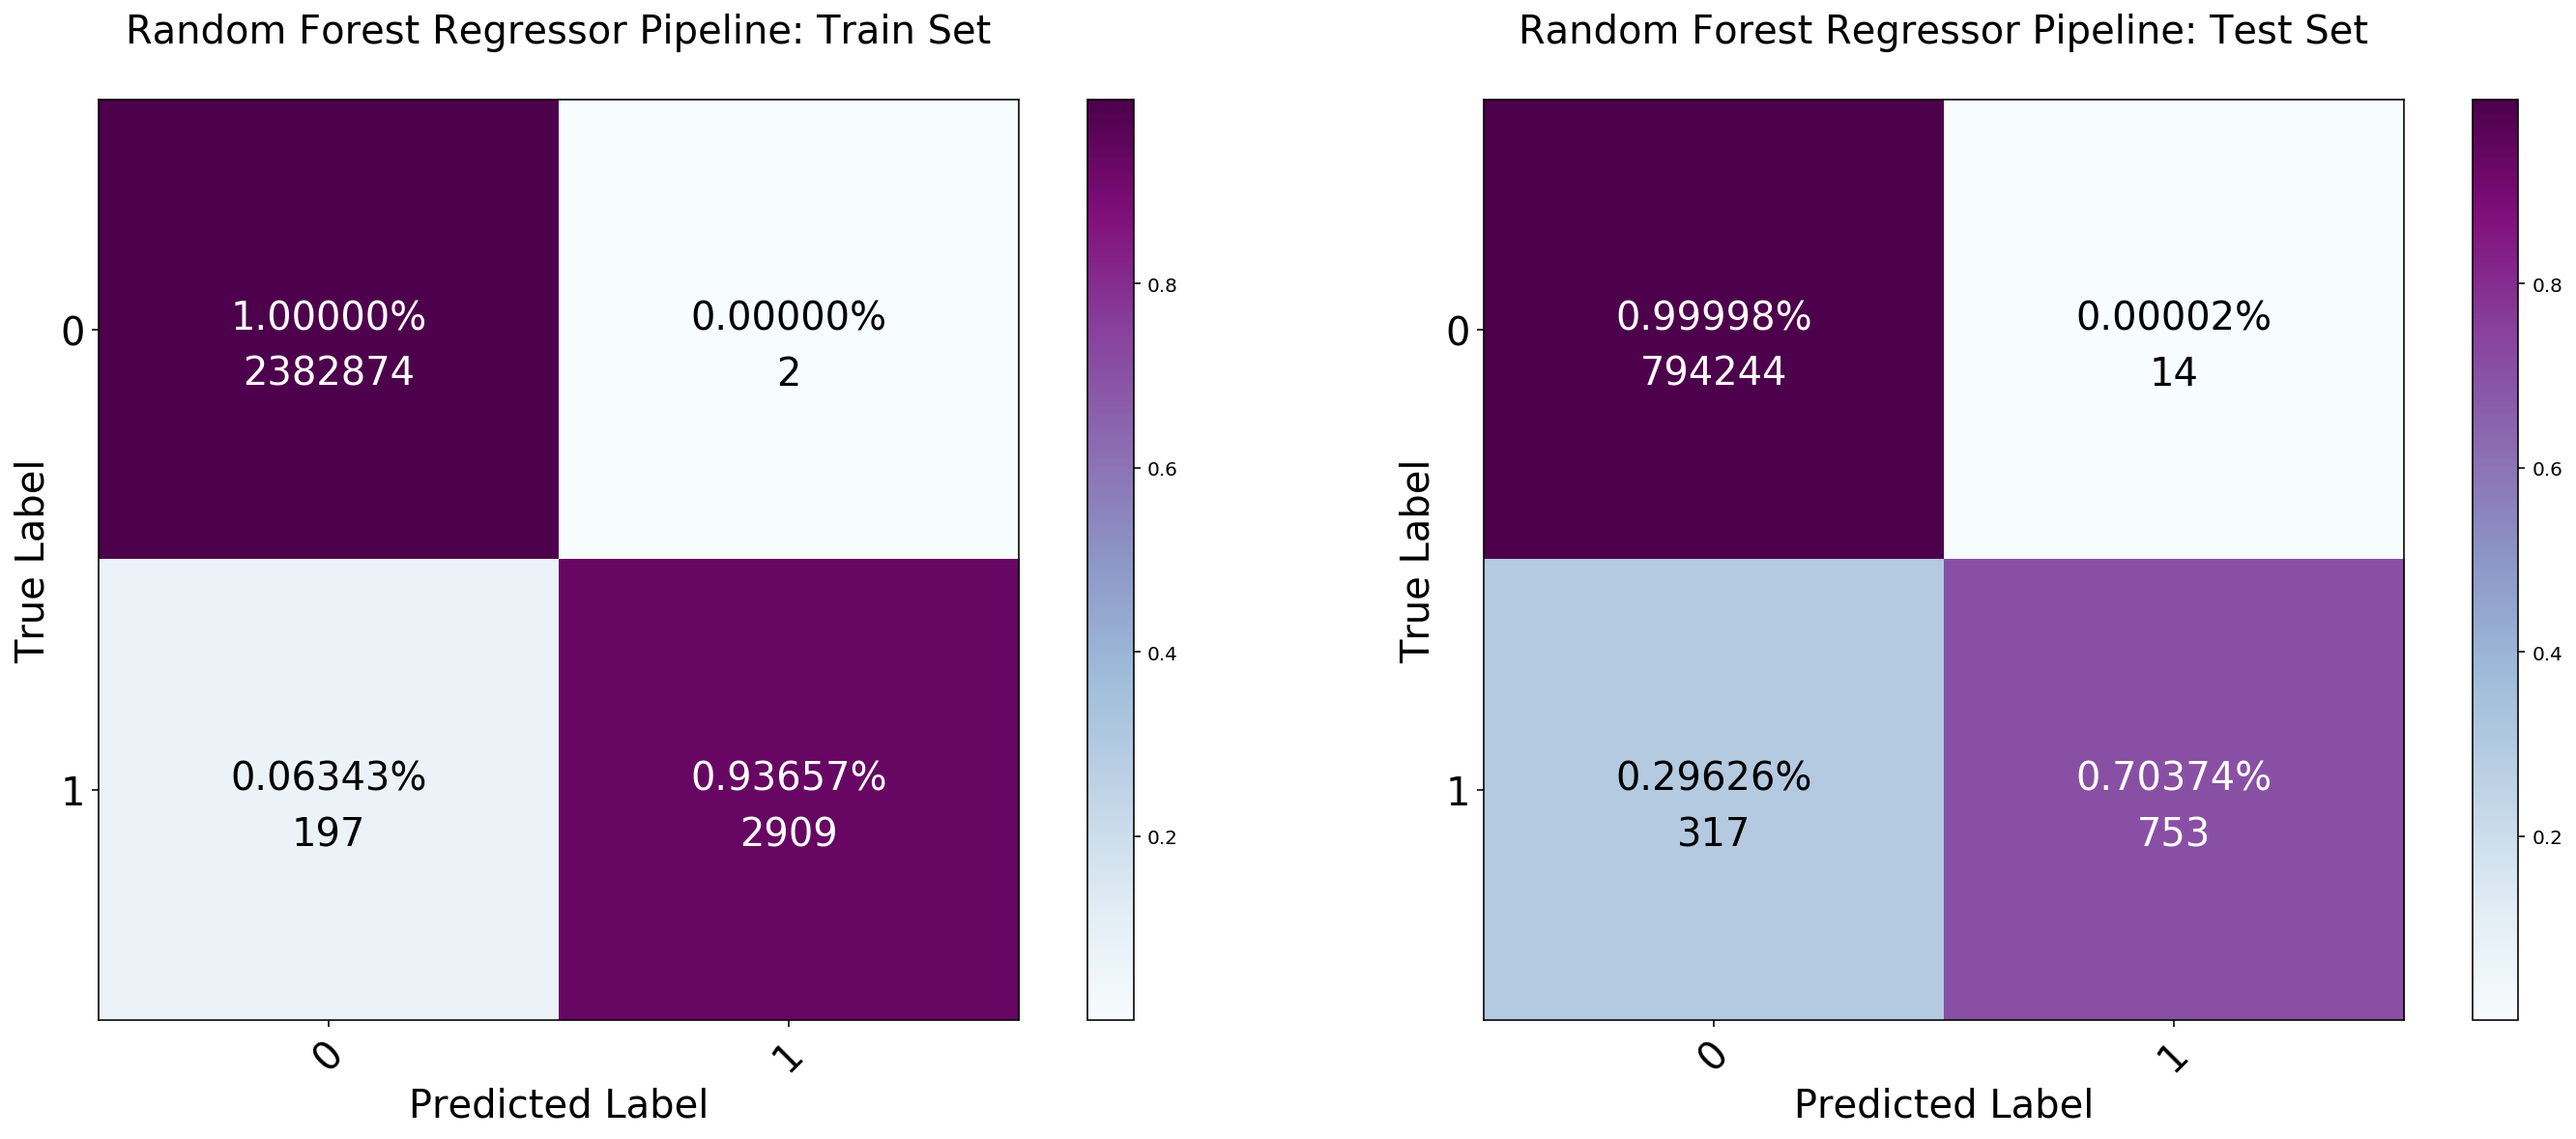

In [63]:
# Build Support Vector Machien Pipeline
rfr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            RandomForestClassifier(n_jobs=-1))
# Run some cross validation on the pipeline
rfr_scores = cross_validate(rfr_pipeline, X_train, y_train, cv=5, 
                           scoring=['accuracy','precision','recall',
                                    'f1','roc_auc'],
                           fit_params={'randomforestclassifier__sample_weight':weights})

# Fit the pipline and return predictions
rfr_pipeline.fit(X_train,y_train, **{'randomforestclassifier__sample_weight':weights})
rfr_pred = rfr_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(rfr_pipeline, 'Models/fraud_rfr_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_normal(model=rfr_pipeline, classes=[0,1], 
                      name = 'Random Forest Regressor Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)


In [42]:
# View rfr model Scores
rfr_score_df = pd.DataFrame(rfr_scores).T
rfr_score_df['Mean'] = rfr_score_df.mean(axis=1)
rfr_score_df['Mean']

fit_time          24.940
score_time         1.472
test_accuracy      1.000
train_accuracy     1.000
test_precision     0.972
train_precision    1.000
test_recall        0.690
train_recall       0.933
test_f1            0.807
train_f1           0.965
test_roc_auc       0.916
train_roc_auc      1.000
Name: Mean, dtype: float64

#### Holdout Scores

In [60]:
# Encode all object colunms to categorical codes
sdf_holdout.type = sdf_holdout.type.astype('category').cat.codes
sdf_holdout.nameorig = sdf_holdout.nameorig.astype('category').cat.codes
sdf_holdout.namedest = sdf_holdout.namedest.astype('category').cat.codes

# Drop is flagged false column
sdf_holdout = sdf_holdout.drop('isflaggedfraud', axis=1)

# Concatenate one-hot encoded type features
sdf_holdout = pd.concat([sdf_holdout,pd.get_dummies(sdf_holdout.type, 'type')], axis=1).drop('type',axis=1)

X_holdout = sdf_holdout.drop('target', axis=1).values
y_holdout = sdf_holdout.target.values

In [74]:
rfr_pipline = joblib.load('Models/fraud_rfr_pipeline.sav')
xgb_pipline = joblib.load('Models/fraud_xgb_pipeline.sav')
print('RFR Pipeline ROC AUC Score:',roc_auc_score(y_holdout, rfr_pipline.predict(X_holdout)))
print('RFR Pipeline F1 Score:',f1_score(y_holdout, rfr_pipline.predict(X_holdout)), '\n')
print('XGB Pipeline ROC AUC Score:',roc_auc_score(y_holdout, xgb_pipline.predict(X_holdout)))
print('XGB Pipeline F1 Score:',f1_score(y_holdout, xgb_pipline.predict(X_holdout)))


RFR Pipeline ROC AUC Score: 0.8887620290754292
RFR Pipeline F1 Score: 0.8699044800215255
XGB Pipeline ROC AUC Score: 0.9706609948671079
XGB Pipeline F1 Score: 0.07470818557919623


Use the ROC AUC and F1 score together I can tell our Random Forest model is more desirable. It balances the trade off between as precision and recall a in better manner. Next I will conduct a grid search on this model and optimize it a bit further.

<a id='autoencoder'></a>
##### Tangent: Auto Encoders

An autoencoder is a specialized neural network that tries to reconstruct our data after passing the data through a bottleneck within the neural network. We can measure the network performance by measuring its reconstruction error (how different the new data from the training data). A high reconstruction error can be a sign of a fraudulent transaction. As data points that are hard to reconstruct would be anomalies. How does the model know how many points are fraudulent? The number of the points to be declared "fraudulent" by the model would be dependent on a predefined threshold we pass through at the end. 

I created an autoencoder for my capstone, to show that the methodology could be applied to this problem. I have decided to remove the code from this notebook, as the model I created did not perform so well. The reasoning around the poor performance is because most of the fraudulent data points are nested so tightly around the low amounts. The current features in this dataset are not predictive enough. The model performed poorly on locating tightly nested anomalies using a threshold. 

### Grid Search

In [6]:
# Setting up the grid
rfr_pipeline = joblib.load('Models/fraud_rfr_pipeline.sav')

grid = {'randomforestclassifier__n_estimators':np.arange(0,200,50)[1:],
        'randomforestclassifier__max_leaf_nodes':[5,50,100,150,200,250]}

# Initialize with GridSearchCV with grid
grid_search = GridSearchCV(estimator=rfr_pipeline, param_grid=grid, 
                     scoring='f1', n_jobs=-1, refit=True, cv=5,
                     return_train_score=True, verbose =1)
# Fit search
grid_search.fit(X_train,y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 202.8min finished


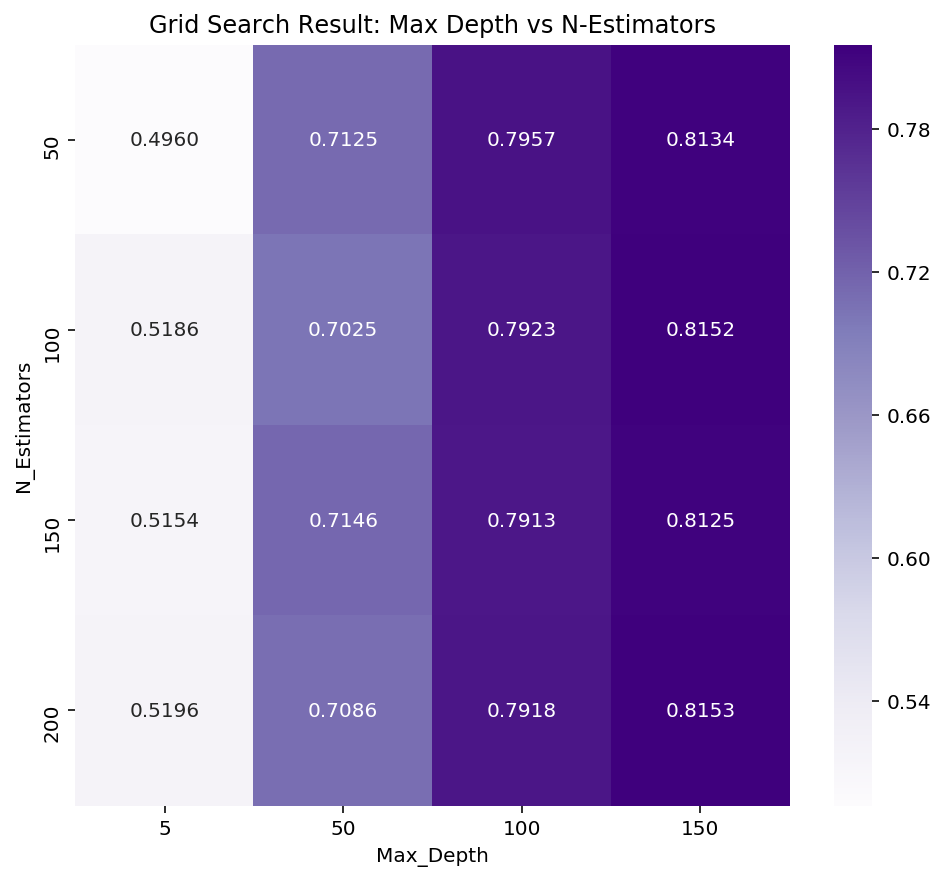

In [8]:
pipeline_results = pd.DataFrame(grid_search.cv_results_)

# Plot grid search results
plt.figure(figsize = (8.0, 7.0))
sns.heatmap(grid_search_groupby(pipeline_results,
                                'randomforestclassifier__n_estimators',
                                'randomforestclassifier__max_leaf_nodes'),
           cmap=plt.cm.Purples, annot=True, fmt='.4f');
plt.title('Grid Search Result: Max Depth vs N-Estimators');
plt.xlabel('Max_Depth')
plt.ylabel('N_Estimators');

### Conclusion

From my talks with people in the industry around Toronto. Tree-based models are the currently the defacto algorithm to use in Fraud detection with a relational database. For further predictive/descriptives power in your modeling, I would suggest reading up on graph databases or attempt to wire your data threw neural network. 

If you wish, You can view the first draft of my capstone in [github](https://github.com/kavisek/Fraud-Detection-Capstone)

### Sources

-- [AutoEncoders in Keras](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)<br>
-- [Coloring Decitions Trees](https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz)<br>
-- [Density Based Clustering](https://www.youtube.com/watch?v=5cOhL4B5waU)<br>
-- [HDSCAN](https://www.youtube.com/watch?v=AgPQ76RIi6A)<br>
-- [Mean Shift Clustering](https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/)<br>
-- [Oultier  Detection](https://plot.ly/scikit-learn/plot-outlier-detection/)<br>


Author: Kavi Sekhon